# tutorial https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

## Note to Jose
Working version but not fully understood yet
The next commented think can allow to remove stuff

In [1]:
# Download TorchVision repo to use some files from
# references/detection
!git clone git@github.com:jcmayoral/PyTorch-YOLOv3.git yolov3

fatal: destination path 'yolov3' already exists and is not an empty directory.


In [2]:
from yolov3.models import Darknet

#model_4classes = Darknet(config_path="yolov3/config/yolov3-custom.cfg")

In [3]:
#nparams = sum(p.numel() for p in model_4classes.parameters())
#print (f"{nparams:,}")

In [4]:
!ls
!pwd

'attempt yolo-binary.ipynb'	   __pycache__
'attempt yolo.ipynb'		   rcnntutorial.ipynb
 checkpoints			   scalar
 coco_eval.py			   svmpersons.ipynb
 coco_utils.py			   testimageyolo.jpg
 decisiontreepersons.ipynb	   testingyolo
 engine.py			   transforms.py
 linearregressionpersons.ipynb	   utils.py
 logisticregressionpersons.ipynb   vision
 output				   yolov3
 pointnet.ipynb
/home/jose/ros_ws/src/gr_perception/gr_ml/nb


In [5]:
bs = 2
nepochs = 20
ncpu = 6
gradient_accumulations = 2
evaluation_interval = 2
checkpoint_interval = 2
img_size = 416

In [6]:
from __future__ import division

from yolov3.models import *
from yolov3.utils.logger import *
from yolov3.utils.utils import *
from yolov3.utils.datasets import *
from yolov3.utils.parse_config import *
from yolov3.test import evaluate

from terminaltables import AsciiTable

import os
import sys
import time
import datetime
import argparse

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim


"""
parser.add_argument("--epochs", type=int, default=100, help="number of epochs")
parser.add_argument("--batch_size", type=int, default=8, help="size of each image batch")
parser.add_argument("--gradient_accumulations", type=int, default=2, help="number of gradient accums before step")
parser.add_argument("--model_def", type=str, default="config/yolov3.cfg", help="path to model definition file")
parser.add_argument("--data_config", type=str, default="config/coco.data", help="path to data config file")
parser.add_argument("--pretrained_weights", type=str, help="if specified starts from checkpoint model")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--img_size", type=int, default=416, help="size of each image dimension")
parser.add_argument("--checkpoint_interval", type=int, default=1, help="interval between saving model weights")
parser.add_argument("--evaluation_interval", type=int, default=1, help="interval evaluations on validation set")
parser.add_argument("--compute_map", default=False, help="if True computes mAP every tenth batch")
parser.add_argument("--multiscale_training", default=True, help="allow for multi-scale training")
opt = parser.parse_args()
print(opt)
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("output", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# Get data configuration
data_config = parse_data_config("yolov3/config/jose.data")
#data_config = { line.split()[0] : line.split()[1] for line in open("yolov3/config/jose.data") }

#parse_data_config(opt.data_config)bb
train_path = data_config["train"]
valid_path = data_config["valid"]
class_names = load_classes(data_config["names"])

print(class_names)

# Initiate model
model = Darknet("yolov3/config/yolov3-custom.cfg").to(device)#, img_size=img_size).to(device)
model.apply(weights_init_normal)

# If specified we start from checkpoint
"""
if opt.pretrained_weights:
    if opt.pretrained_weights.endswith(".pth"):
        model.load_state_dict(torch.load(opt.pretrained_weights))
    else:
        model.load_darknet_weights(opt.pretrained_weights)
"""



/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWa

['Lethal', 'Danger', 'Warning', 'Safe']


'\nif opt.pretrained_weights:\n    if opt.pretrained_weights.endswith(".pth"):\n        model.load_state_dict(torch.load(opt.pretrained_weights))\n    else:\n        model.load_darknet_weights(opt.pretrained_weights)\n'

In [7]:
!pwd


/home/jose/ros_ws/src/gr_perception/gr_ml/nb


In [8]:
# Get dataloader
#For some reason augment or multiscale fails
dataset = ListDataset(train_path, augment=False, multiscale=False)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=bs,
    shuffle=True,
    num_workers=ncpu,
    pin_memory=False,
    collate_fn=dataset.collate_fn,
)

optimizer = torch.optim.Adam(model.parameters())

metrics = [
    "grid_size",
    "loss",
    "x",
    "y",
    "w",
    "h",
    "conf",
    "cls",
    "cls_acc",
    "recall50",
    "recall75",
    "precision",
    "conf_obj",
    "conf_noobj",
]

try:
    os.makedirs("testingyolo")
except:
    pass

#logger = Logger("testingyolo/logs")


for epoch in range(nepochs):
    model.train()
    start_time = time.time()
    for batch_i, (_, imgs, targets) in enumerate(dataloader):
        #print(_)
        batches_done = len(dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
        targets = Variable(targets.to(device), requires_grad=False)

        loss, outputs = model(imgs, targets)
        loss.backward()

        if batches_done % gradient_accumulations:
            # Accumulates gradient before each step
            optimizer.step()
            optimizer.zero_grad()

        # ----------------
        #   Log progress
        # ----------------

        log_str = "\n---- [Epoch %d/%d, Batch %d/%d] ----\n" % (epoch, nepochs, batch_i, len(dataloader))

        metric_table = [["Metrics", *[f"YOLO Layer {i}" for i in range(len(model.yolo_layers))]]]

        # Log metrics at each YOLO layer
        for i, metric in enumerate(metrics):
            formats = {m: "%.6f" for m in metrics}
            formats["grid_size"] = "%2d"
            formats["cls_acc"] = "%.2f%%"
            row_metrics = [formats[metric] % yolo.metrics.get(metric, 0) for yolo in model.yolo_layers]
            metric_table += [[metric, *row_metrics]]

            # Tensorboard logging
            tensorboard_log = []
            for j, yolo in enumerate(model.yolo_layers):
                for name, metric in yolo.metrics.items():
                    if name != "grid_size":
                        tensorboard_log += [(f"{name}_{j+1}", metric)]
            tensorboard_log += [("loss", loss.item())]
            #logger.list_of_scalars_summary(tensorboard_log, batches_done)

        log_str += AsciiTable(metric_table).table
        log_str += f"\nTotal loss {loss.item()}"

        # Determine approximate time left for epoch
        epoch_batches_left = len(dataloader) - (batch_i + 1)
        time_left = datetime.timedelta(seconds=epoch_batches_left * (time.time() - start_time) / (batch_i + 1))
        log_str += f"\n---- ETA {time_left}"

        print(log_str)

        model.seen += imgs.size(0)

    if epoch % evaluation_interval == 0:
        print("\n---- Evaluating Model ----")
        # Evaluate the model on the validation set
        precision, recall, AP, f1, ap_class = evaluate(
            model,
            path=valid_path,
            iou_thres=0.5,
            conf_thres=0.5,
            nms_thres=0.5,
            img_size=img_size,
            batch_size=8,
        )
        """
        evaluation_metrics = [
            ("val_precision", precision.mean()),
            ("val_recall", recall.mean()),
            ("val_mAP", AP.mean()),
            ("val_f1", f1.mean()),
        ]
        logger.list_of_scalars_summary(evaluation_metrics, epoch)
        """
        # Print class APs and mAP
        ap_table = [["Index", "Class name", "AP"]]
        for i, c in enumerate(ap_class):
            ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
        print(AsciiTable(ap_table).table)
        print(f"---- mAP {AP.mean()}")

    if epoch % checkpoint_interval == 0:
        torch.save(model.state_dict(), f"testingyolo/checkpoints/yolov3_ckpt_%d.pth" % epoch)



---- [Epoch 0/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 76.278481    | 80.904190    | 70.902100    |
| x          | 0.063035     | 0.139764     | 0.043880     |
| y          | 0.122729     | 0.065518     | 0.056017     |
| w          | 1.849284     | 0.941949     | 0.431017     |
| h          | 2.677916     | 0.745239     | 1.093995     |
| conf       | 70.862732    | 78.294121    | 68.593819    |
| cls        | 0.702784     | 0.717597     | 0.683369     |
| cls_acc    | 33.33%       | 0.00%        | 66.67%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.478447     | 0.534773     | 0.494384     |
| co


---- [Epoch 0/20, Batch 8/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 43.294563    | 42.286812    | 51.399643    |
| x          | 0.116101     | 0.103152     | 0.134786     |
| y          | 0.066434     | 0.147393     | 0.216117     |
| w          | 7.142586     | 0.521917     | 0.245669     |
| h          | 8.795925     | 0.270179     | 0.292386     |
| conf       | 26.632988    | 40.606457    | 49.887974    |
| cls        | 0.540528     | 0.637714     | 0.622710     |
| cls_acc    | 33.33%       | 0.00%        | 66.67%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.217247     | 0.364009     | 0.336013     |
| co


---- [Epoch 0/20, Batch 16/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 10.170592    | 22.524014    | 34.966068    |
| x          | 0.099574     | 0.107509     | 0.097736     |
| y          | 0.081499     | 0.041570     | 0.081343     |
| w          | 0.133436     | 0.567689     | 0.263856     |
| h          | 0.113992     | 0.517714     | 0.593500     |
| conf       | 9.158304     | 20.668396    | 33.376183    |
| cls        | 0.583787     | 0.621135     | 0.553450     |
| cls_acc    | 25.00%       | 0.00%        | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.128566     | 0.252600     | 0.311601     |
| c


---- [Epoch 0/20, Batch 23/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 10.743152    | 14.712569    | 26.788589    |
| x          | 0.110026     | 0.069165     | 0.082676     |
| y          | 0.006698     | 0.064369     | 0.031315     |
| w          | 1.809710     | 0.213271     | 0.051605     |
| h          | 1.544823     | 0.161081     | 0.001535     |
| conf       | 6.711474     | 13.688057    | 26.038296    |
| cls        | 0.560421     | 0.516628     | 0.583161     |
| cls_acc    | 0.00%        | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.155850     | 0.245007     | 0.267649     |
| c


---- [Epoch 0/20, Batch 31/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 7.497502     | 9.692615     | 20.687263    |
| x          | 0.058863     | 0.031102     | 0.206407     |
| y          | 0.016519     | 0.006321     | 0.087211     |
| w          | 0.811148     | 0.178404     | 0.387332     |
| h          | 1.608026     | 0.240602     | 0.366575     |
| conf       | 4.573553     | 8.745159     | 19.054249    |
| cls        | 0.429394     | 0.491027     | 0.585487     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.064094     | 0.176601     | 0.223979     |
| c


---- [Epoch 0/20, Batch 38/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.737974     | 8.659150     | 16.257633    |
| x          | 0.142404     | 0.101283     | 0.036228     |
| y          | 0.036344     | 0.043225     | 0.029758     |
| w          | 0.402918     | 0.284438     | 0.769310     |
| h          | 0.592369     | 0.421857     | 0.773232     |
| conf       | 3.974343     | 7.415434     | 14.075621    |
| cls        | 0.589595     | 0.392914     | 0.573485     |
| cls_acc    | 33.33%       | 66.67%       | 66.67%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.079713     | 0.052451     | 0.168772     |
| c


---- [Epoch 0/20, Batch 45/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.098458     | 5.519984     | 12.042054    |
| x          | 0.143938     | 0.060185     | 0.035199     |
| y          | 0.068117     | 0.072031     | 0.023237     |
| w          | 0.198033     | 0.087929     | 0.019769     |
| h          | 0.512769     | 0.030525     | 0.145520     |
| conf       | 2.687935     | 4.798615     | 11.291355    |
| cls        | 0.487666     | 0.470699     | 0.526974     |
| cls_acc    | 0.00%        | 50.00%       | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.250981     | 0.208495     | 0.225602     |
| c


---- [Epoch 0/20, Batch 52/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.266099     | 4.519506     | 9.643265     |
| x          | 0.098643     | 0.088689     | 0.082502     |
| y          | 0.042001     | 0.038938     | 0.161131     |
| w          | 0.183218     | 0.021863     | 0.154981     |
| h          | 0.102181     | 0.032593     | 0.510349     |
| conf       | 2.505358     | 3.944917     | 8.297671     |
| cls        | 0.334698     | 0.392505     | 0.436630     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.331431     | 0.255381     | 0.433320     |
| c


---- [Epoch 0/20, Batch 59/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 8.521490     | 8.317334     | 9.976462     |
| x          | 0.042570     | 0.062087     | 0.065626     |
| y          | 0.075960     | 0.035965     | 0.094890     |
| w          | 0.850477     | 0.948803     | 0.152827     |
| h          | 1.299809     | 0.731459     | 0.404220     |
| conf       | 5.564378     | 6.078475     | 8.840660     |
| cls        | 0.688295     | 0.460545     | 0.418240     |
| cls_acc    | 0.00%        | 66.67%       | 66.67%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.033441     | 0.022345     | 0.058377     |
| c


---- [Epoch 0/20, Batch 66/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 7.607742     | 6.362908     | 8.914016     |
| x          | 0.027033     | 0.021487     | 0.163143     |
| y          | 0.319089     | 0.183681     | 0.074213     |
| w          | 0.737795     | 0.657659     | 0.857338     |
| h          | 0.657377     | 0.077817     | 0.220659     |
| conf       | 5.337354     | 5.038734     | 7.178607     |
| cls        | 0.529093     | 0.383530     | 0.420055     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.018874     | 0.047674     | 0.290587     |
| c

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 0/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 7.153706     | 7.390935     | 8.496080     |
| x          | 0.154026     | 0.207899     | 0.037814     |
| y          | 0.084163     | 0.100616     | 0.208257     |
| w          | 0.163320     | 0.170117     | 0.128339     |
| h          | 0.683623     | 1.017719     | 0.000286     |
| conf       | 6.050107     | 5.770699     | 7.591331     |
| cls        | 0.018465     | 0.123885     | 0.530053     |
| cls_acc    | 100.00%      | 100.00%      | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.004715     | 0.013335     | 0.075172     |
| c

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 8213.39it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.00000 |
| 2     | Warning    | 0.10309 |
+-------+------------+---------+
---- mAP 0.03436226298068403

---- [Epoch 1/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.122847     | 5.238386     | 7.386674     |
| x          | 0.080604     | 0.006232     | 0.120723     |
| y          | 0.074092     | 0.106441     | 0.004652     |
| w          | 0.322361     | 0.230624     | 0.169211     |
| h          | 0.528880     | 0.250208     | 0.020194     |
| conf       | 3.795559     | 4.318394     | 6.513224     |
| cls        | 0.321352     | 0.326488     | 0.558670     |
| cls_acc    | 50.00%       | 100.00%      |


---- [Epoch 1/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.501740     | 6.736103     | 7.570704     |
| x          | 0.094477     | 0.028871     | 0.112338     |
| y          | 0.024947     | 0.094364     | 0.048552     |
| w          | 0.592179     | 0.374035     | 0.173801     |
| h          | 0.268169     | 0.533862     | 0.252157     |
| conf       | 2.936094     | 4.929308     | 6.273064     |
| cls        | 0.585874     | 0.775662     | 0.710792     |
| cls_acc    | 0.00%        | 0.00%        | 33.33%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.104881     | 0.033630     | 0.088874     |
| co


---- [Epoch 1/20, Batch 15/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.594008     | 3.935408     | 4.353806     |
| x          | 0.054664     | 0.049362     | 0.044934     |
| y          | 0.061871     | 0.038901     | 0.000151     |
| w          | 0.102706     | 0.057180     | 0.001749     |
| h          | 0.245372     | 0.025810     | 0.012147     |
| conf       | 2.552061     | 3.259880     | 3.809903     |
| cls        | 0.577334     | 0.504274     | 0.484922     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.270776     | 0.300124     | 0.582654     |
| c


---- [Epoch 1/20, Batch 22/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.051991     | 5.281211     | 5.139118     |
| x          | 0.048560     | 0.136570     | 0.101117     |
| y          | 0.047516     | 0.142260     | 0.100725     |
| w          | 0.055305     | 0.087778     | 0.100772     |
| h          | 0.584381     | 0.050329     | 0.060674     |
| conf       | 4.050446     | 4.638301     | 4.280571     |
| cls        | 0.265782     | 0.225973     | 0.495259     |
| cls_acc    | 66.67%       | 100.00%      | 33.33%       |
| recall50   | 0.000000     | 0.000000     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.021277     |
| conf_obj   | 0.208852     | 0.114907     | 0.394607     |
| c


---- [Epoch 1/20, Batch 29/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.277708     | 4.543092     | 5.184795     |
| x          | 0.179669     | 0.079850     | 0.123365     |
| y          | 0.132661     | 0.059491     | 0.126551     |
| w          | 0.246913     | 0.137026     | 0.141354     |
| h          | 0.081774     | 0.150806     | 0.314728     |
| conf       | 3.319696     | 3.811492     | 3.956748     |
| cls        | 0.316993     | 0.304427     | 0.522049     |
| cls_acc    | 66.67%       | 100.00%      | 33.33%       |
| recall50   | 0.000000     | 0.000000     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.019231     |
| conf_obj   | 0.149633     | 0.155971     | 0.458466     |
| c


---- [Epoch 1/20, Batch 36/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.941978     | 5.083632     | 5.411785     |
| x          | 0.071606     | 0.029848     | 0.088146     |
| y          | 0.090699     | 0.038669     | 0.111947     |
| w          | 0.135139     | 0.103729     | 0.317178     |
| h          | 0.213825     | 0.117071     | 0.188984     |
| conf       | 4.074244     | 4.407828     | 4.161158     |
| cls        | 0.356466     | 0.386488     | 0.544372     |
| cls_acc    | 50.00%       | 75.00%       | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.101374     | 0.132367     | 0.283136     |
| c


---- [Epoch 1/20, Batch 43/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.717815     | 5.699972     | 5.335868     |
| x          | 0.037144     | 0.004287     | 0.144863     |
| y          | 0.025385     | 0.039141     | 0.107660     |
| w          | 0.569734     | 0.888086     | 0.303507     |
| h          | 0.002311     | 0.115744     | 0.010691     |
| conf       | 4.680536     | 4.280905     | 4.426549     |
| cls        | 0.402706     | 0.371809     | 0.342597     |
| cls_acc    | 66.67%       | 66.67%       | 66.67%       |
| recall50   | 0.000000     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.333333     |
| precision  | 0.000000     | 1.000000     | 0.111111     |
| conf_obj   | 0.044288     | 0.187660     | 0.218884     |
| c


---- [Epoch 1/20, Batch 50/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.424200     | 4.875694     | 6.013372     |
| x          | 0.054399     | 0.033790     | 0.077867     |
| y          | 0.026209     | 0.042673     | 0.044337     |
| w          | 0.372092     | 0.281810     | 0.067337     |
| h          | 0.504355     | 0.388865     | 0.492266     |
| conf       | 2.946064     | 3.674305     | 4.775345     |
| cls        | 0.521082     | 0.454252     | 0.556221     |
| cls_acc    | 33.33%       | 66.67%       | 66.67%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.109834     | 0.078038     | 0.064625     |
| c


---- [Epoch 1/20, Batch 57/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.855800     | 3.805316     | 4.472562     |
| x          | 0.055903     | 0.055056     | 0.092143     |
| y          | 0.001231     | 0.001811     | 0.023099     |
| w          | 0.642505     | 0.202084     | 0.134460     |
| h          | 1.006410     | 0.113728     | 0.068732     |
| conf       | 2.721293     | 3.078524     | 3.878547     |
| cls        | 0.428459     | 0.354114     | 0.275582     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.172084     | 0.233788     | 0.110974     |
| c


---- [Epoch 1/20, Batch 64/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 7.478133     | 5.482218     | 6.477462     |
| x          | 0.055306     | 0.097803     | 0.272933     |
| y          | 0.008557     | 0.003991     | 0.019575     |
| w          | 1.247288     | 0.524074     | 0.126099     |
| h          | 2.015732     | 0.557022     | 0.021489     |
| conf       | 3.600114     | 4.100026     | 5.973209     |
| cls        | 0.551135     | 0.199302     | 0.064157     |
| cls_acc    | 0.00%        | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.093827     | 0.038014     | 0.019967     |
| c


---- [Epoch 2/20, Batch 3/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 6.190453     | 3.467454     | 4.358662     |
| x          | 0.078567     | 0.039564     | 0.107102     |
| y          | 0.008181     | 0.035634     | 0.088808     |
| w          | 0.168847     | 0.715708     | 0.516928     |
| h          | 0.615890     | 0.470031     | 0.422795     |
| conf       | 4.800057     | 1.666317     | 2.708283     |
| cls        | 0.518912     | 0.540200     | 0.514745     |
| cls_acc    | 50.00%       | 0.00%        | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.032596     | 0.710797     | 0.367890     |
| co


---- [Epoch 2/20, Batch 11/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.338427     | 1.970857     | 2.630823     |
| x          | 0.030798     | 0.061797     | 0.054374     |
| y          | 0.000883     | 0.039828     | 0.013499     |
| w          | 0.020430     | 0.017830     | 0.102369     |
| h          | 0.000791     | 0.003509     | 0.040708     |
| conf       | 3.007207     | 1.520041     | 2.056580     |
| cls        | 0.278318     | 0.327852     | 0.363293     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 1.000000     | 1.000000     |
| recall75   | 0.000000     | 1.000000     | 0.000000     |
| precision  | 0.000000     | 0.133333     | 0.042553     |
| conf_obj   | 0.160904     | 0.754506     | 0.726402     |
| c


---- [Epoch 2/20, Batch 18/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.817130     | 3.190134     | 2.767286     |
| x          | 0.242093     | 0.190780     | 0.148683     |
| y          | 0.123966     | 0.079279     | 0.013293     |
| w          | 0.179319     | 0.038388     | 0.078896     |
| h          | 0.058982     | 0.062810     | 0.058139     |
| conf       | 2.908761     | 2.414886     | 2.055676     |
| cls        | 0.304009     | 0.403990     | 0.412601     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.500000     |
| precision  | 0.000000     | 0.200000     | 0.020408     |
| conf_obj   | 0.205664     | 0.361643     | 0.735545     |
| c


---- [Epoch 2/20, Batch 25/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.240054     | 3.383973     | 3.351702     |
| x          | 0.059432     | 0.097499     | 0.126505     |
| y          | 0.069936     | 0.094409     | 0.118356     |
| w          | 0.218013     | 0.039669     | 0.019915     |
| h          | 0.241259     | 0.072866     | 0.079719     |
| conf       | 3.299112     | 2.600685     | 2.514538     |
| cls        | 0.352302     | 0.478845     | 0.492668     |
| cls_acc    | 50.00%       | 25.00%       | 25.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.125341     | 0.505250     | 0.591434     |
| c


---- [Epoch 2/20, Batch 32/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.680856     | 3.025988     | 3.312435     |
| x          | 0.004605     | 0.155604     | 0.061727     |
| y          | 0.076930     | 0.004193     | 0.021275     |
| w          | 0.154455     | 0.073209     | 0.121468     |
| h          | 0.199632     | 0.006932     | 0.051848     |
| conf       | 2.877558     | 2.572388     | 2.840865     |
| cls        | 0.367676     | 0.213663     | 0.215253     |
| cls_acc    | 50.00%       | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.250000     | 0.045455     |
| conf_obj   | 0.118989     | 0.298254     | 0.462877     |
| c


---- [Epoch 2/20, Batch 39/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.102672     | 4.197173     | 4.422423     |
| x          | 0.115048     | 0.092259     | 0.008841     |
| y          | 0.018911     | 0.068817     | 0.135470     |
| w          | 0.459078     | 0.003867     | 0.052564     |
| h          | 0.488351     | 0.219577     | 0.435086     |
| conf       | 3.624161     | 3.021324     | 3.235490     |
| cls        | 0.397124     | 0.791329     | 0.554972     |
| cls_acc    | 33.33%       | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.079718     | 0.284479     | 0.495451     |
| c


---- [Epoch 2/20, Batch 46/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.524321     | 3.902457     | 3.860296     |
| x          | 0.084491     | 0.094489     | 0.124104     |
| y          | 0.094735     | 0.129328     | 0.059793     |
| w          | 0.388346     | 0.182095     | 0.075518     |
| h          | 0.785278     | 0.132117     | 0.150734     |
| conf       | 3.730395     | 2.875099     | 3.035789     |
| cls        | 0.441076     | 0.489329     | 0.414358     |
| cls_acc    | 33.33%       | 33.33%       | 66.67%       |
| recall50   | 0.000000     | 0.000000     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.050000     |
| conf_obj   | 0.091637     | 0.318572     | 0.371107     |
| c


---- [Epoch 2/20, Batch 53/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.615615     | 3.811551     | 2.710111     |
| x          | 0.015155     | 0.081529     | 0.063443     |
| y          | 0.050283     | 0.055999     | 0.059250     |
| w          | 0.029887     | 0.013324     | 0.054753     |
| h          | 0.053315     | 0.060263     | 0.093431     |
| conf       | 4.162737     | 3.399674     | 2.013138     |
| cls        | 0.304238     | 0.200761     | 0.426095     |
| cls_acc    | 66.67%       | 100.00%      | 66.67%       |
| recall50   | 0.000000     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.333333     | 0.333333     |
| precision  | 0.000000     | 0.100000     | 0.013889     |
| conf_obj   | 0.145983     | 0.247016     | 0.702926     |
| c


---- [Epoch 2/20, Batch 60/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.502376     | 4.885759     | 3.831325     |
| x          | 0.093399     | 0.170518     | 0.213772     |
| y          | 0.054470     | 0.139329     | 0.109128     |
| w          | 0.685219     | 0.296559     | 0.190789     |
| h          | 0.909195     | 0.313121     | 0.136699     |
| conf       | 3.369422     | 3.583259     | 2.917521     |
| cls        | 0.390671     | 0.382973     | 0.263416     |
| cls_acc    | 33.33%       | 66.67%       | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.207548     | 0.073667     | 0.417564     |
| c


---- [Epoch 2/20, Batch 67/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.634442     | 2.805356     | 2.710874     |
| x          | 0.094137     | 0.110788     | 0.005753     |
| y          | 0.082377     | 0.045755     | 0.107781     |
| w          | 0.040162     | 0.054690     | 0.018630     |
| h          | 0.148002     | 0.111052     | 0.151082     |
| conf       | 2.845815     | 2.085643     | 2.079878     |
| cls        | 0.423950     | 0.397428     | 0.347750     |
| cls_acc    | 66.67%       | 66.67%       | 100.00%      |
| recall50   | 0.000000     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.333333     |
| precision  | 0.000000     | 0.083333     | 0.027027     |
| conf_obj   | 0.192962     | 0.523545     | 0.508657     |
| c

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 2/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.420602     | 2.934134     | 3.830660     |
| x          | 0.049991     | 0.019901     | 0.076001     |
| y          | 0.012422     | 0.018105     | 0.042098     |
| w          | 0.855151     | 0.317807     | 0.232121     |
| h          | 0.642660     | 0.012788     | 0.002327     |
| conf       | 2.465179     | 2.455712     | 3.426229     |
| cls        | 0.395197     | 0.109821     | 0.051884     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.216385     | 0.169988     | 0.100296     |
| c

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 5660.33it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.00000 |
| 2     | Warning    | 0.44583 |
+-------+------------+---------+
---- mAP 0.14860909174473577

---- [Epoch 3/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.111767     | 4.082694     | 4.349138     |
| x          | 0.048975     | 0.023065     | 0.221511     |
| y          | 0.073233     | 0.112425     | 0.088493     |
| w          | 0.195394     | 0.044932     | 0.111630     |
| h          | 0.162329     | 0.046503     | 0.013398     |
| conf       | 4.347562     | 3.561044     | 3.668120     |
| cls        | 0.284273     | 0.294725     | 0.245987     |
| cls_acc    | 50.00%       | 50.00%       |


---- [Epoch 3/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.038792     | 2.691185     | 2.103718     |
| x          | 0.081973     | 0.126340     | 0.099566     |
| y          | 0.046211     | 0.008548     | 0.026196     |
| w          | 0.660824     | 0.138887     | 0.017466     |
| h          | 1.354652     | 0.159182     | 0.001050     |
| conf       | 2.472734     | 1.592642     | 1.560138     |
| cls        | 0.422398     | 0.665586     | 0.399303     |
| cls_acc    | 50.00%       | 0.00%        | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.500000     |
| precision  | 0.000000     | 0.000000     | 0.034483     |
| conf_obj   | 0.287369     | 0.687357     | 0.679632     |
| co


---- [Epoch 3/20, Batch 15/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.795884     | 1.831079     | 1.919405     |
| x          | 0.096471     | 0.041090     | 0.041556     |
| y          | 0.000911     | 0.011430     | 0.050272     |
| w          | 0.028114     | 0.038924     | 0.010067     |
| h          | 0.031760     | 0.046585     | 0.011800     |
| conf       | 2.247871     | 1.220109     | 1.402072     |
| cls        | 0.390758     | 0.472940     | 0.403639     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.500000     |
| precision  | 0.000000     | 0.200000     | 0.023256     |
| conf_obj   | 0.280591     | 0.625233     | 0.842535     |
| c


---- [Epoch 3/20, Batch 23/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.635482     | 8.080540     | 7.035577     |
| x          | 0.041500     | 0.002940     | 0.090495     |
| y          | 0.011728     | 0.033070     | 0.000495     |
| w          | 0.144415     | 0.465609     | 0.099599     |
| h          | 0.002133     | 0.462082     | 0.036435     |
| conf       | 2.861539     | 6.359714     | 6.246020     |
| cls        | 0.574167     | 0.757124     | 0.562533     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.145202     | 0.004131     | 0.005460     |
| c


---- [Epoch 3/20, Batch 30/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.256163     | 3.563209     | 2.948487     |
| x          | 0.049984     | 0.102317     | 0.055068     |
| y          | 0.025116     | 0.031644     | 0.089681     |
| w          | 0.083397     | 0.320505     | 0.123697     |
| h          | 0.132429     | 0.197710     | 0.224418     |
| conf       | 3.639977     | 2.354214     | 2.016033     |
| cls        | 0.325260     | 0.556818     | 0.439590     |
| cls_acc    | 33.33%       | 33.33%       | 66.67%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.169862     | 0.506823     | 0.482094     |
| c


---- [Epoch 3/20, Batch 37/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.320185     | 3.916244     | 3.692902     |
| x          | 0.068519     | 0.060789     | 0.051379     |
| y          | 0.010346     | 0.078764     | 0.172568     |
| w          | 0.205785     | 0.032899     | 0.054842     |
| h          | 0.109499     | 0.186090     | 0.102442     |
| conf       | 4.629642     | 3.295883     | 3.007998     |
| cls        | 0.296393     | 0.261819     | 0.303671     |
| cls_acc    | 100.00%      | 66.67%       | 66.67%       |
| recall50   | 0.000000     | 0.000000     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.041667     |
| conf_obj   | 0.081917     | 0.280249     | 0.430175     |
| c


---- [Epoch 3/20, Batch 44/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.923251     | 2.429260     | 2.246555     |
| x          | 0.005839     | 0.089044     | 0.175872     |
| y          | 0.045141     | 0.022719     | 0.009062     |
| w          | 0.045158     | 0.048590     | 0.072140     |
| h          | 0.013009     | 0.012553     | 0.006136     |
| conf       | 2.507329     | 2.028599     | 1.783726     |
| cls        | 0.306775     | 0.227756     | 0.199620     |
| cls_acc    | 100.00%      | 50.00%       | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.028571     |
| conf_obj   | 0.259967     | 0.426988     | 0.645344     |
| c


---- [Epoch 3/20, Batch 52/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.830580     | 3.275826     | 3.193682     |
| x          | 0.045246     | 0.069205     | 0.164089     |
| y          | 0.049556     | 0.006141     | 0.097558     |
| w          | 0.282675     | 0.039758     | 0.037683     |
| h          | 0.067300     | 0.066060     | 0.070743     |
| conf       | 3.047428     | 2.660987     | 2.275289     |
| cls        | 0.338373     | 0.433675     | 0.548321     |
| cls_acc    | 33.33%       | 66.67%       | 33.33%       |
| recall50   | 0.000000     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.090909     | 0.000000     |
| conf_obj   | 0.168042     | 0.475830     | 0.465925     |
| c


---- [Epoch 3/20, Batch 60/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.910500     | 3.813565     | 3.648018     |
| x          | 0.129974     | 0.096068     | 0.041407     |
| y          | 0.037844     | 0.029913     | 0.158299     |
| w          | 0.111207     | 0.029991     | 0.070579     |
| h          | 0.135454     | 0.061731     | 0.029882     |
| conf       | 4.290780     | 3.396757     | 2.894932     |
| cls        | 0.205241     | 0.199106     | 0.452918     |
| cls_acc    | 66.67%       | 100.00%      | 33.33%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.067607     | 0.197823     | 0.509155     |
| c


---- [Epoch 3/20, Batch 67/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.302855     | 2.937376     | 2.672433     |
| x          | 0.058460     | 0.116654     | 0.127073     |
| y          | 0.043437     | 0.021953     | 0.050678     |
| w          | 0.186333     | 0.188266     | 0.348429     |
| h          | 0.056393     | 0.177274     | 0.102500     |
| conf       | 2.510839     | 1.973506     | 1.582366     |
| cls        | 0.447393     | 0.459723     | 0.461386     |
| cls_acc    | 25.00%       | 50.00%       | 25.00%       |
| recall50   | 0.000000     | 0.000000     | 0.250000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.021739     |
| conf_obj   | 0.207677     | 0.426003     | 0.675629     |
| c


---- [Epoch 4/20, Batch 6/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.666669     | 1.885529     | 2.822487     |
| x          | 0.060342     | 0.024919     | 0.061995     |
| y          | 0.031446     | 0.135477     | 0.064500     |
| w          | 0.135510     | 0.030145     | 0.011049     |
| h          | 0.067909     | 0.009032     | 0.017994     |
| conf       | 3.010467     | 1.246490     | 2.222045     |
| cls        | 0.360994     | 0.439466     | 0.444904     |
| cls_acc    | 66.67%       | 33.33%       | 33.33%       |
| recall50   | 0.000000     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.000000     | 0.100000     | 0.000000     |
| conf_obj   | 0.139772     | 0.766969     | 0.538854     |
| co


---- [Epoch 4/20, Batch 14/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.783901     | 2.311640     | 2.538130     |
| x          | 0.110869     | 0.033556     | 0.137097     |
| y          | 0.016272     | 0.083671     | 0.095421     |
| w          | 0.409413     | 0.073941     | 0.029004     |
| h          | 0.566827     | 0.005083     | 0.028960     |
| conf       | 2.292001     | 1.916821     | 2.022331     |
| cls        | 0.388519     | 0.198568     | 0.225318     |
| cls_acc    | 50.00%       | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.500000     |
| precision  | 0.000000     | 0.250000     | 0.041667     |
| conf_obj   | 0.287507     | 0.462162     | 0.514576     |
| c


---- [Epoch 4/20, Batch 21/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.262006     | 2.478179     | 3.279461     |
| x          | 0.031394     | 0.111565     | 0.103795     |
| y          | 0.053223     | 0.048372     | 0.187634     |
| w          | 0.334826     | 0.141577     | 0.260191     |
| h          | 0.462272     | 0.152588     | 0.676440     |
| conf       | 3.068686     | 1.585070     | 1.606870     |
| cls        | 0.311604     | 0.439006     | 0.444530     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.014493     |
| conf_obj   | 0.202740     | 0.668589     | 0.878134     |
| c


---- [Epoch 4/20, Batch 29/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.502570     | 1.957798     | 2.222804     |
| x          | 0.064595     | 0.017126     | 0.133607     |
| y          | 0.024936     | 0.034024     | 0.112295     |
| w          | 0.026239     | 0.153098     | 0.054528     |
| h          | 0.073844     | 0.069107     | 0.135925     |
| conf       | 3.167353     | 1.413431     | 1.373383     |
| cls        | 0.145603     | 0.271013     | 0.413064     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.500000     |
| precision  | 0.000000     | 0.083333     | 0.071429     |
| conf_obj   | 0.214888     | 0.666861     | 0.569053     |
| c


---- [Epoch 4/20, Batch 36/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.157106     | 2.782145     | 3.195905     |
| x          | 0.123986     | 0.013657     | 0.055643     |
| y          | 0.068312     | 0.036791     | 0.061377     |
| w          | 0.325785     | 0.010341     | 0.300361     |
| h          | 0.348511     | 0.067712     | 0.253285     |
| conf       | 3.046010     | 2.386656     | 2.112025     |
| cls        | 0.244503     | 0.266988     | 0.413215     |
| cls_acc    | 66.67%       | 100.00%      | 33.33%       |
| recall50   | 0.333333     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 1.000000     | 0.125000     | 0.000000     |
| conf_obj   | 0.234114     | 0.386670     | 0.385319     |
| c


---- [Epoch 4/20, Batch 44/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.734353     | 1.499796     | 1.874518     |
| x          | 0.119876     | 0.061309     | 0.016889     |
| y          | 0.006051     | 0.009490     | 0.021897     |
| w          | 0.067743     | 0.029482     | 0.020454     |
| h          | 0.050503     | 0.059173     | 0.195914     |
| conf       | 2.034124     | 0.932016     | 1.262253     |
| cls        | 0.456056     | 0.408326     | 0.357112     |
| cls_acc    | 0.00%        | 0.00%        | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 1.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.040816     |
| conf_obj   | 0.324224     | 0.798572     | 0.884044     |
| c


---- [Epoch 4/20, Batch 51/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.882496     | 2.329342     | 2.366432     |
| x          | 0.051558     | 0.048680     | 0.132392     |
| y          | 0.005112     | 0.010681     | 0.058450     |
| w          | 0.208767     | 0.193349     | 0.007888     |
| h          | 0.126800     | 0.226201     | 0.287788     |
| conf       | 2.600654     | 1.168503     | 1.350930     |
| cls        | 0.889604     | 0.681927     | 0.528984     |
| cls_acc    | 50.00%       | 0.00%        | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.015385     |
| conf_obj   | 0.259436     | 0.635675     | 0.811925     |
| c


---- [Epoch 4/20, Batch 59/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.682323     | 2.373385     | 1.881779     |
| x          | 0.103580     | 0.058632     | 0.097823     |
| y          | 0.023737     | 0.032795     | 0.031697     |
| w          | 0.037757     | 0.032218     | 0.026819     |
| h          | 0.016743     | 0.106225     | 0.167117     |
| conf       | 2.164746     | 1.809273     | 1.179218     |
| cls        | 0.335759     | 0.334242     | 0.379106     |
| cls_acc    | 100.00%      | 100.00%      | 75.00%       |
| recall50   | 0.250000     | 0.250000     | 0.750000     |
| recall75   | 0.250000     | 0.250000     | 0.000000     |
| precision  | 1.000000     | 0.125000     | 0.142857     |
| conf_obj   | 0.311802     | 0.466002     | 0.626571     |
| c


---- [Epoch 4/20, Batch 67/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.542948     | 1.768638     | 2.519100     |
| x          | 0.006148     | 0.094075     | 0.039004     |
| y          | 0.022813     | 0.058824     | 0.052591     |
| w          | 0.029987     | 0.006571     | 0.096629     |
| h          | 0.103325     | 0.077324     | 0.271021     |
| conf       | 2.119190     | 1.209394     | 1.733124     |
| cls        | 0.261486     | 0.322450     | 0.326731     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.076923     | 0.000000     |
| conf_obj   | 0.318772     | 0.691226     | 0.535473     |
| c

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 4/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.710476     | 1.626007     | 2.107036     |
| x          | 0.213173     | 0.138850     | 0.232460     |
| y          | 0.183035     | 0.083954     | 0.042938     |
| w          | 0.001140     | 0.060335     | 0.007228     |
| h          | 0.000235     | 0.006215     | 0.114216     |
| conf       | 2.023933     | 0.918673     | 1.216902     |
| cls        | 0.288959     | 0.417980     | 0.493293     |
| cls_acc    | 100.00%      | 100.00%      | 0.00%        |
| recall50   | 0.000000     | 1.000000     | 0.000000     |
| recall75   | 0.000000     | 1.000000     | 0.000000     |
| precision  | 0.000000     | 0.200000     | 0.000000     |
| conf_obj   | 0.236041     | 0.806183     | 0.846607     |
| c

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 4361.49it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.24111 |
| 2     | Warning    | 0.55296 |
+-------+------------+---------+
---- mAP 0.2646914857955316

---- [Epoch 5/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.013318     | 2.000427     | 2.080321     |
| x          | 0.133835     | 0.096445     | 0.108822     |
| y          | 0.026374     | 0.096132     | 0.048047     |
| w          | 0.141531     | 0.127536     | 0.110540     |
| h          | 0.011040     | 0.054232     | 0.104953     |
| conf       | 2.402351     | 1.175411     | 1.216156     |
| cls        | 0.298187     | 0.450671     | 0.491803     |
| cls_acc    | 66.67%       | 33.33%       | 


---- [Epoch 5/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.738360     | 1.752879     | 2.053965     |
| x          | 0.037972     | 0.071298     | 0.038095     |
| y          | 0.034936     | 0.076582     | 0.056567     |
| w          | 0.071280     | 0.061242     | 0.087386     |
| h          | 0.047486     | 0.108628     | 0.237033     |
| conf       | 2.287094     | 0.945976     | 1.189314     |
| cls        | 0.259592     | 0.489152     | 0.445569     |
| cls_acc    | 100.00%      | 66.67%       | 66.67%       |
| recall50   | 0.000000     | 0.666667     | 0.666667     |
| recall75   | 0.000000     | 0.666667     | 0.666667     |
| precision  | 0.000000     | 0.153846     | 0.066667     |
| conf_obj   | 0.247586     | 0.779146     | 0.692582     |
| co


---- [Epoch 5/20, Batch 15/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.961817     | 1.383482     | 1.526243     |
| x          | 0.156869     | 0.076139     | 0.093849     |
| y          | 0.025479     | 0.009238     | 0.110538     |
| w          | 0.144423     | 0.036437     | 0.029782     |
| h          | 0.125306     | 0.000258     | 0.008983     |
| conf       | 1.903426     | 0.821689     | 0.871561     |
| cls        | 0.606314     | 0.439720     | 0.411531     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.500000     |
| precision  | 0.000000     | 0.142857     | 0.037037     |
| conf_obj   | 0.458448     | 0.820449     | 0.859467     |
| c


---- [Epoch 5/20, Batch 23/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.860717     | 3.127417     | 2.817582     |
| x          | 0.089546     | 0.034795     | 0.043257     |
| y          | 0.010178     | 0.106330     | 0.066349     |
| w          | 0.157623     | 0.105645     | 0.240818     |
| h          | 0.232226     | 0.024717     | 0.027788     |
| conf       | 2.992266     | 2.525367     | 2.131618     |
| cls        | 0.378878     | 0.330562     | 0.307751     |
| cls_acc    | 66.67%       | 66.67%       | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.333333     | 0.333333     | 0.333333     |
| precision  | 0.500000     | 0.250000     | 0.047619     |
| conf_obj   | 0.228349     | 0.351852     | 0.413273     |
| c


---- [Epoch 5/20, Batch 31/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.560581     | 1.974703     | 2.167536     |
| x          | 0.113821     | 0.058123     | 0.128251     |
| y          | 0.050818     | 0.121907     | 0.103257     |
| w          | 0.128325     | 0.082731     | 0.029746     |
| h          | 0.087759     | 0.028221     | 0.052117     |
| conf       | 2.901361     | 1.442903     | 1.579835     |
| cls        | 0.278498     | 0.240818     | 0.274330     |
| cls_acc    | 75.00%       | 100.00%      | 75.00%       |
| recall50   | 0.000000     | 0.750000     | 0.250000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.187500     | 0.030303     |
| conf_obj   | 0.304425     | 0.682734     | 0.548296     |
| c


---- [Epoch 5/20, Batch 39/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.455309     | 1.641419     | 1.783143     |
| x          | 0.000519     | 0.035150     | 0.203188     |
| y          | 0.024038     | 0.004487     | 0.093520     |
| w          | 0.044109     | 0.057028     | 0.070235     |
| h          | 0.011935     | 0.189364     | 0.054539     |
| conf       | 1.114734     | 1.105534     | 1.190161     |
| cls        | 0.259975     | 0.249856     | 0.171500     |
| cls_acc    | 100.00%      | 50.00%       | 100.00%      |
| recall50   | 0.500000     | 0.000000     | 1.000000     |
| recall75   | 0.500000     | 0.000000     | 0.500000     |
| precision  | 1.000000     | 0.000000     | 0.054054     |
| conf_obj   | 0.555918     | 0.678331     | 0.784512     |
| c


---- [Epoch 5/20, Batch 47/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.731971     | 1.625864     | 2.175198     |
| x          | 0.026955     | 0.065045     | 0.028007     |
| y          | 0.033732     | 0.012855     | 0.135986     |
| w          | 0.024552     | 0.023474     | 0.007837     |
| h          | 0.044845     | 0.017858     | 0.050189     |
| conf       | 1.273759     | 1.071483     | 1.595180     |
| cls        | 0.328126     | 0.435149     | 0.357999     |
| cls_acc    | 66.67%       | 33.33%       | 100.00%      |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.333333     | 0.333333     |
| precision  | 0.500000     | 0.071429     | 0.041667     |
| conf_obj   | 0.536411     | 0.829413     | 0.468580     |
| c


---- [Epoch 5/20, Batch 55/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.306416     | 3.712381     | 3.204716     |
| x          | 0.132717     | 0.087584     | 0.105947     |
| y          | 0.069695     | 0.110413     | 0.208311     |
| w          | 0.092172     | 0.184997     | 0.015460     |
| h          | 0.093414     | 0.228870     | 0.002572     |
| conf       | 3.668859     | 2.758878     | 2.588281     |
| cls        | 0.249559     | 0.341639     | 0.284144     |
| cls_acc    | 66.67%       | 66.67%       | 66.67%       |
| recall50   | 0.000000     | 0.000000     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.333333     |
| precision  | 0.000000     | 0.000000     | 0.062500     |
| conf_obj   | 0.187904     | 0.228776     | 0.461189     |
| c


---- [Epoch 5/20, Batch 62/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.400425     | 4.888678     | 3.952090     |
| x          | 0.067891     | 0.093177     | 0.034319     |
| y          | 0.012293     | 0.087139     | 0.094759     |
| w          | 0.019777     | 0.647877     | 0.412723     |
| h          | 0.007041     | 0.277163     | 0.397518     |
| conf       | 4.016553     | 3.714378     | 2.747608     |
| cls        | 0.276870     | 0.068945     | 0.265163     |
| cls_acc    | 66.67%       | 100.00%      | 66.67%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.187243     | 0.206095     | 0.562483     |
| c


---- [Epoch 6/20, Batch 1/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.703941     | 1.316507     | 1.463371     |
| x          | 0.035777     | 0.015870     | 0.017415     |
| y          | 0.001659     | 0.011638     | 0.033326     |
| w          | 0.002194     | 0.001356     | 0.022736     |
| h          | 0.006110     | 0.044435     | 0.003688     |
| conf       | 1.302817     | 0.868833     | 0.991828     |
| cls        | 0.355384     | 0.374375     | 0.394378     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.500000     | 0.500000     |
| precision  | 0.125000     | 0.125000     | 0.023810     |
| conf_obj   | 0.706159     | 0.818082     | 0.929386     |
| co


---- [Epoch 6/20, Batch 9/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.728786     | 4.500682     | 2.212701     |
| x          | 0.130334     | 0.214270     | 0.141683     |
| y          | 0.148437     | 0.064905     | 0.018118     |
| w          | 0.259265     | 0.193029     | 0.231731     |
| h          | 0.043682     | 0.357680     | 0.024226     |
| conf       | 3.035980     | 3.009594     | 1.439485     |
| cls        | 0.111088     | 0.661203     | 0.357458     |
| cls_acc    | 100.00%      | 0.00%        | 50.00%       |
| recall50   | 0.500000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.000000     | 0.000000     |
| conf_obj   | 0.285534     | 0.337013     | 0.469199     |
| co


---- [Epoch 6/20, Batch 17/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.044450     | 3.549589     | 3.698121     |
| x          | 0.116739     | 0.010452     | 0.102067     |
| y          | 0.054980     | 0.010291     | 0.011459     |
| w          | 0.085389     | 0.056080     | 0.059450     |
| h          | 0.034577     | 0.032793     | 0.068612     |
| conf       | 3.554059     | 3.253423     | 3.278999     |
| cls        | 0.198706     | 0.186550     | 0.177534     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 1.000000     | 0.200000     | 0.071429     |
| conf_obj   | 0.348919     | 0.478322     | 0.428933     |
| c


---- [Epoch 6/20, Batch 25/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.390141     | 2.216697     | 2.613997     |
| x          | 0.084220     | 0.023509     | 0.250032     |
| y          | 0.011615     | 0.082340     | 0.089861     |
| w          | 0.193898     | 0.469748     | 0.217310     |
| h          | 0.077193     | 0.023916     | 0.232713     |
| conf       | 1.859698     | 1.063701     | 1.182051     |
| cls        | 0.163518     | 0.553483     | 0.642030     |
| cls_acc    | 100.00%      | 50.00%       | 0.00%        |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.066667     | 0.000000     |
| conf_obj   | 0.476350     | 0.751941     | 0.729276     |
| c


---- [Epoch 6/20, Batch 33/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.287894     | 1.771030     | 3.066140     |
| x          | 0.080525     | 0.031948     | 0.195557     |
| y          | 0.013427     | 0.101662     | 0.060357     |
| w          | 0.166950     | 0.022498     | 0.363473     |
| h          | 0.044660     | 0.019796     | 0.258628     |
| conf       | 1.493545     | 1.140166     | 1.193572     |
| cls        | 0.488787     | 0.454960     | 0.994553     |
| cls_acc    | 66.67%       | 66.67%       | 0.00%        |
| recall50   | 0.333333     | 0.666667     | 0.000000     |
| recall75   | 0.000000     | 0.666667     | 0.000000     |
| precision  | 0.333333     | 0.250000     | 0.000000     |
| conf_obj   | 0.514004     | 0.661223     | 0.678515     |
| c


---- [Epoch 6/20, Batch 41/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.974489     | 1.468019     | 1.929991     |
| x          | 0.057311     | 0.059076     | 0.083445     |
| y          | 0.040656     | 0.055762     | 0.059617     |
| w          | 0.083189     | 0.028948     | 0.285351     |
| h          | 0.180793     | 0.011821     | 0.410637     |
| conf       | 1.264327     | 0.907646     | 0.684685     |
| cls        | 0.348214     | 0.404766     | 0.406256     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.500000     | 1.000000     | 0.000000     |
| recall75   | 0.000000     | 1.000000     | 0.000000     |
| precision  | 0.250000     | 0.285714     | 0.000000     |
| conf_obj   | 0.567012     | 0.693370     | 0.880784     |
| c


---- [Epoch 6/20, Batch 49/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 10.934897    | 11.181806    | 10.224797    |
| x          | 0.202720     | 0.000090     | 0.166102     |
| y          | 0.232617     | 0.024339     | 0.010702     |
| w          | 2.225456     | 2.066118     | 2.386837     |
| h          | 0.003109     | 0.024890     | 0.598825     |
| conf       | 8.264104     | 9.034493     | 6.659457     |
| cls        | 0.006892     | 0.031875     | 0.402873     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.000631     | 0.000218     | 0.002757     |
| c


---- [Epoch 6/20, Batch 57/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.857508     | 1.631233     | 1.760836     |
| x          | 0.045932     | 0.010271     | 0.136233     |
| y          | 0.020443     | 0.064379     | 0.095242     |
| w          | 0.029624     | 0.014008     | 0.122476     |
| h          | 0.141273     | 0.111236     | 0.093527     |
| conf       | 1.219083     | 1.077146     | 0.919170     |
| cls        | 0.401153     | 0.354192     | 0.394189     |
| cls_acc    | 50.00%       | 25.00%       | 50.00%       |
| recall50   | 0.500000     | 0.000000     | 0.250000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.000000     | 0.032258     |
| conf_obj   | 0.635885     | 0.691952     | 0.769861     |
| c


---- [Epoch 6/20, Batch 65/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.237723     | 2.188824     | 1.564515     |
| x          | 0.109286     | 0.071480     | 0.069075     |
| y          | 0.044038     | 0.067276     | 0.097390     |
| w          | 0.183678     | 0.030106     | 0.009968     |
| h          | 0.165459     | 0.057638     | 0.086976     |
| conf       | 1.366458     | 1.582910     | 0.910574     |
| cls        | 0.368806     | 0.379414     | 0.390533     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.666667     | 0.666667     | 1.000000     |
| recall75   | 0.000000     | 0.333333     | 0.666667     |
| precision  | 0.666667     | 0.400000     | 0.115385     |
| conf_obj   | 0.496865     | 0.503669     | 0.772161     |
| c

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 6/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.922218     | 1.804465     | 2.359533     |
| x          | 0.114698     | 0.139692     | 0.278113     |
| y          | 0.033717     | 0.013663     | 0.068315     |
| w          | 0.445401     | 0.013807     | 0.006170     |
| h          | 0.562559     | 0.025776     | 0.069007     |
| conf       | 1.578874     | 1.171338     | 1.447539     |
| cls        | 1.186969     | 0.440188     | 0.490390     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.495012     | 0.588384     | 0.427839     |
| c

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 4549.14it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.44606 |
| 2     | Warning    | 0.78051 |
+-------+------------+---------+
---- mAP 0.40885838131548913

---- [Epoch 7/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.185483     | 6.083217     | 4.184420     |
| x          | 0.011439     | 0.050765     | 0.258258     |
| y          | 0.192073     | 0.091750     | 0.028997     |
| w          | 0.424703     | 0.664511     | 0.036335     |
| h          | 0.233013     | 1.074844     | 0.031026     |
| conf       | 4.143684     | 4.194911     | 3.816864     |
| cls        | 0.180570     | 0.006435     | 0.012940     |
| cls_acc    | 100.00%      | 100.00%      |


---- [Epoch 7/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.265150     | 2.200809     | 1.266159     |
| x          | 0.008680     | 0.133010     | 0.074951     |
| y          | 0.001007     | 0.019284     | 0.041025     |
| w          | 0.226230     | 0.429736     | 0.067410     |
| h          | 0.068662     | 0.512123     | 0.096510     |
| conf       | 0.800292     | 0.902721     | 0.806653     |
| cls        | 0.160279     | 0.203934     | 0.179610     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 0.500000     | 1.000000     |
| recall75   | 0.500000     | 0.000000     | 0.500000     |
| precision  | 0.666667     | 0.125000     | 0.090909     |
| conf_obj   | 0.699275     | 0.740156     | 0.844776     |
| co


---- [Epoch 7/20, Batch 15/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.317468     | 1.597771     | 1.315723     |
| x          | 0.099998     | 0.091096     | 0.135720     |
| y          | 0.006451     | 0.049720     | 0.090859     |
| w          | 0.166738     | 0.094868     | 0.072143     |
| h          | 0.155062     | 0.291733     | 0.031575     |
| conf       | 0.701354     | 0.865875     | 0.790393     |
| cls        | 0.187865     | 0.204479     | 0.195033     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 1.000000     | 1.000000     | 0.500000     |
| recall75   | 0.500000     | 0.500000     | 0.000000     |
| precision  | 0.666667     | 0.333333     | 0.037037     |
| conf_obj   | 0.824338     | 0.767731     | 0.905698     |
| c


---- [Epoch 7/20, Batch 22/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.048209     | 2.036650     | 1.400616     |
| x          | 0.016325     | 0.144960     | 0.113362     |
| y          | 0.029516     | 0.027295     | 0.109221     |
| w          | 0.738330     | 0.423038     | 0.102626     |
| h          | 0.588705     | 0.255735     | 0.110352     |
| conf       | 1.337574     | 0.992671     | 0.760162     |
| cls        | 0.337758     | 0.192951     | 0.204892     |
| cls_acc    | 50.00%       | 100.00%      | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.500000     | 0.333333     | 0.043478     |
| conf_obj   | 0.556272     | 0.643571     | 0.878725     |
| c


---- [Epoch 7/20, Batch 30/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.503710     | 1.399323     | 1.818131     |
| x          | 0.029534     | 0.031142     | 0.029620     |
| y          | 0.025974     | 0.020275     | 0.098339     |
| w          | 0.024964     | 0.034656     | 0.237263     |
| h          | 0.092502     | 0.005420     | 0.084504     |
| conf       | 0.947723     | 0.804931     | 0.910904     |
| cls        | 0.383012     | 0.502899     | 0.457500     |
| cls_acc    | 33.33%       | 33.33%       | 33.33%       |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.250000     | 0.076923     | 0.076923     |
| conf_obj   | 0.781118     | 0.870878     | 0.615066     |
| c


---- [Epoch 7/20, Batch 38/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.176322     | 2.803630     | 2.983782     |
| x          | 0.061372     | 0.051912     | 0.105813     |
| y          | 0.015874     | 0.113863     | 0.032414     |
| w          | 0.059162     | 0.005308     | 0.254725     |
| h          | 0.022857     | 0.055574     | 0.186556     |
| conf       | 1.559176     | 1.836219     | 1.699891     |
| cls        | 0.457881     | 0.740753     | 0.704383     |
| cls_acc    | 33.33%       | 0.00%        | 33.33%       |
| recall50   | 0.333333     | 0.000000     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 1.000000     | 0.000000     | 0.033333     |
| conf_obj   | 0.394952     | 0.378375     | 0.457510     |
| c


---- [Epoch 7/20, Batch 46/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.247862     | 1.775865     | 2.184216     |
| x          | 0.065231     | 0.074081     | 0.140893     |
| y          | 0.017495     | 0.066766     | 0.133375     |
| w          | 0.087727     | 0.088473     | 0.231319     |
| h          | 0.101364     | 0.054251     | 0.352769     |
| conf       | 1.689252     | 1.092691     | 0.899766     |
| cls        | 0.286794     | 0.399603     | 0.426094     |
| cls_acc    | 33.33%       | 33.33%       | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.666667     |
| recall75   | 0.000000     | 0.000000     | 0.333333     |
| precision  | 0.166667     | 0.055556     | 0.042553     |
| conf_obj   | 0.558871     | 0.850805     | 0.906611     |
| c


---- [Epoch 7/20, Batch 54/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.568620     | 1.243615     | 1.320402     |
| x          | 0.005042     | 0.004914     | 0.045354     |
| y          | 0.007383     | 0.033401     | 0.034619     |
| w          | 0.078157     | 0.037831     | 0.027856     |
| h          | 0.015514     | 0.076823     | 0.046071     |
| conf       | 1.048328     | 0.766588     | 0.774075     |
| cls        | 0.414196     | 0.324057     | 0.392427     |
| cls_acc    | 33.33%       | 100.00%      | 66.67%       |
| recall50   | 0.333333     | 1.000000     | 0.666667     |
| recall75   | 0.333333     | 0.333333     | 0.000000     |
| precision  | 0.166667     | 0.300000     | 0.076923     |
| conf_obj   | 0.781916     | 0.797657     | 0.786595     |
| c


---- [Epoch 7/20, Batch 61/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.994825     | 2.618975     | 3.447949     |
| x          | 0.042629     | 0.173153     | 0.124252     |
| y          | 0.051365     | 0.028908     | 0.007317     |
| w          | 0.274517     | 0.157305     | 0.121177     |
| h          | 0.137041     | 0.224692     | 0.104191     |
| conf       | 2.308794     | 1.767066     | 2.881392     |
| cls        | 0.180478     | 0.267851     | 0.209620     |
| cls_acc    | 66.67%       | 66.67%       | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.029412     |
| conf_obj   | 0.308345     | 0.353852     | 0.246821     |
| c


---- [Epoch 8/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.159831     | 1.739898     | 1.693463     |
| x          | 0.012339     | 0.031216     | 0.036825     |
| y          | 0.012116     | 0.044483     | 0.043221     |
| w          | 0.146006     | 0.111945     | 0.137077     |
| h          | 0.130991     | 0.010966     | 0.127589     |
| conf       | 1.746050     | 1.373507     | 1.063442     |
| cls        | 0.112329     | 0.167781     | 0.285309     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.333333     | 0.666667     | 0.666667     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.400000     | 0.071429     |
| conf_obj   | 0.382827     | 0.459859     | 0.652693     |
| co


---- [Epoch 8/20, Batch 8/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.954751     | 1.406885     | 1.588683     |
| x          | 0.034094     | 0.046489     | 0.014403     |
| y          | 0.016036     | 0.019992     | 0.119519     |
| w          | 0.173952     | 0.052628     | 0.086645     |
| h          | 0.095771     | 0.024151     | 0.097283     |
| conf       | 1.191115     | 0.807147     | 0.899678     |
| cls        | 0.443784     | 0.456479     | 0.371156     |
| cls_acc    | 33.33%       | 33.33%       | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.666667     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.125000     | 0.083333     | 0.048780     |
| conf_obj   | 0.768691     | 0.828641     | 0.835980     |
| co


---- [Epoch 8/20, Batch 16/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.119611     | 2.170514     | 2.026050     |
| x          | 0.074073     | 0.019059     | 0.069521     |
| y          | 0.084537     | 0.139185     | 0.120895     |
| w          | 0.055779     | 0.207699     | 0.158931     |
| h          | 0.006439     | 0.163119     | 0.145576     |
| conf       | 1.572295     | 1.067048     | 0.975132     |
| cls        | 0.326487     | 0.574404     | 0.555995     |
| cls_acc    | 50.00%       | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.515909     | 0.763669     | 0.709645     |
| c


---- [Epoch 8/20, Batch 24/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.174225     | 1.046005     | 1.351215     |
| x          | 0.009698     | 0.033618     | 0.151441     |
| y          | 0.014545     | 0.003045     | 0.022436     |
| w          | 0.008249     | 0.007449     | 0.046443     |
| h          | 0.184594     | 0.020629     | 0.155051     |
| conf       | 0.595843     | 0.554832     | 0.567673     |
| cls        | 0.361296     | 0.426432     | 0.408171     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.333333     | 0.125000     | 0.058824     |
| conf_obj   | 0.839611     | 0.941048     | 0.934654     |
| c


---- [Epoch 8/20, Batch 32/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.281612     | 2.081606     | 2.080034     |
| x          | 0.061508     | 0.006217     | 0.193624     |
| y          | 0.017174     | 0.112317     | 0.108333     |
| w          | 0.004178     | 0.090895     | 0.276675     |
| h          | 0.059152     | 0.071082     | 0.127586     |
| conf       | 3.076525     | 1.437316     | 0.855750     |
| cls        | 0.063074     | 0.363778     | 0.518066     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.032258     |
| conf_obj   | 0.097092     | 0.411909     | 0.771628     |
| c


---- [Epoch 8/20, Batch 39/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.856789     | 1.573212     | 1.962676     |
| x          | 0.038423     | 0.004346     | 0.089344     |
| y          | 0.024861     | 0.050509     | 0.129407     |
| w          | 0.059319     | 0.046836     | 0.133182     |
| h          | 0.226860     | 0.061130     | 0.181403     |
| conf       | 1.238150     | 1.093716     | 0.941949     |
| cls        | 0.269176     | 0.316673     | 0.487390     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.200000     | 0.100000     | 0.000000     |
| conf_obj   | 0.618181     | 0.598462     | 0.701527     |
| c


---- [Epoch 8/20, Batch 47/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.721107     | 1.896521     | 2.193275     |
| x          | 0.009860     | 0.042756     | 0.045289     |
| y          | 0.031745     | 0.052436     | 0.088150     |
| w          | 0.425282     | 0.218648     | 0.168250     |
| h          | 0.536710     | 0.029255     | 0.019977     |
| conf       | 1.329856     | 1.191694     | 1.485938     |
| cls        | 0.387655     | 0.361732     | 0.385670     |
| cls_acc    | 33.33%       | 66.67%       | 33.33%       |
| recall50   | 0.000000     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.000000     | 0.100000     | 0.000000     |
| conf_obj   | 0.574966     | 0.544183     | 0.602581     |
| c


---- [Epoch 8/20, Batch 55/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.082693     | 0.962527     | 1.213529     |
| x          | 0.012777     | 0.044907     | 0.054884     |
| y          | 0.016156     | 0.023767     | 0.004434     |
| w          | 0.295715     | 0.006630     | 0.038227     |
| h          | 0.441737     | 0.000156     | 0.057562     |
| conf       | 1.060361     | 0.637677     | 0.698364     |
| cls        | 0.255947     | 0.249389     | 0.360057     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.500000     | 1.000000     | 0.500000     |
| recall75   | 0.000000     | 1.000000     | 0.000000     |
| precision  | 0.200000     | 0.222222     | 0.040000     |
| conf_obj   | 0.732002     | 0.818410     | 0.919538     |
| c


---- [Epoch 8/20, Batch 63/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.862745     | 1.344234     | 1.115518     |
| x          | 0.028667     | 0.021197     | 0.030394     |
| y          | 0.012446     | 0.002971     | 0.043572     |
| w          | 0.256949     | 0.018851     | 0.015095     |
| h          | 0.413656     | 0.025430     | 0.015996     |
| conf       | 1.612945     | 1.038490     | 0.676933     |
| cls        | 0.538081     | 0.237296     | 0.333529     |
| cls_acc    | 0.00%        | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.666667     | 1.000000     |
| recall75   | 0.000000     | 0.666667     | 1.000000     |
| precision  | 0.000000     | 0.166667     | 0.125000     |
| conf_obj   | 0.586503     | 0.730557     | 0.819536     |
| c

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 8/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.578677     | 4.016243     | 3.796874     |
| x          | 0.274857     | 0.106001     | 0.036839     |
| y          | 0.012606     | 0.048766     | 0.087428     |
| w          | 0.146838     | 0.093755     | 0.161267     |
| h          | 0.264803     | 0.031538     | 0.074443     |
| conf       | 2.595242     | 3.577524     | 3.115546     |
| cls        | 0.284332     | 0.158659     | 0.321353     |
| cls_acc    | 50.00%       | 100.00%      | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.500000     | 0.000000     |
| conf_obj   | 0.340435     | 0.375051     | 0.155768     |
| c

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 4860.14it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.75277 |
| 2     | Warning    | 0.05029 |
+-------+------------+---------+
---- mAP 0.2676835128943661

---- [Epoch 9/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.139799     | 2.002985     | 2.479310     |
| x          | 0.079404     | 0.002776     | 0.089893     |
| y          | 0.066036     | 0.028092     | 0.063606     |
| w          | 0.329018     | 0.043241     | 0.039799     |
| h          | 0.047212     | 0.022596     | 0.158886     |
| conf       | 1.210000     | 1.587405     | 1.638266     |
| cls        | 0.408129     | 0.318876     | 0.488860     |
| cls_acc    | 66.67%       | 66.67%       | 


---- [Epoch 9/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.829334     | 1.180862     | 1.139793     |
| x          | 0.171674     | 0.094941     | 0.059995     |
| y          | 0.012836     | 0.006579     | 0.026782     |
| w          | 0.024951     | 0.103906     | 0.014824     |
| h          | 0.024185     | 0.003400     | 0.052252     |
| conf       | 1.083670     | 0.562772     | 0.641590     |
| cls        | 0.512017     | 0.409264     | 0.344349     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.250000     | 0.125000     | 0.034483     |
| conf_obj   | 0.648214     | 0.868639     | 0.975633     |
| co


---- [Epoch 9/20, Batch 15/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.710468     | 1.711726     | 1.836624     |
| x          | 0.017873     | 0.130749     | 0.109928     |
| y          | 0.081849     | 0.055410     | 0.047123     |
| w          | 0.076195     | 0.117782     | 0.122999     |
| h          | 0.159250     | 0.074482     | 0.081016     |
| conf       | 3.124911     | 0.956548     | 1.181129     |
| cls        | 0.250390     | 0.376753     | 0.294429     |
| cls_acc    | 66.67%       | 66.67%       | 100.00%      |
| recall50   | 0.333333     | 0.666667     | 0.666667     |
| recall75   | 0.333333     | 0.666667     | 0.333333     |
| precision  | 0.200000     | 0.153846     | 0.062500     |
| conf_obj   | 0.265100     | 0.808123     | 0.616746     |
| c


---- [Epoch 9/20, Batch 23/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.675024     | 1.794506     | 1.476322     |
| x          | 0.023602     | 0.006954     | 0.125963     |
| y          | 0.020831     | 0.144078     | 0.054947     |
| w          | 0.073850     | 0.045064     | 0.068445     |
| h          | 0.120226     | 0.151481     | 0.053967     |
| conf       | 1.244408     | 1.189144     | 0.825217     |
| cls        | 0.192106     | 0.257785     | 0.347782     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.100000     | 0.028571     |
| conf_obj   | 0.627641     | 0.685787     | 0.888904     |
| c


---- [Epoch 9/20, Batch 31/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.154789     | 1.472958     | 1.598421     |
| x          | 0.008074     | 0.054128     | 0.024509     |
| y          | 0.003915     | 0.001527     | 0.020681     |
| w          | 0.041205     | 0.013186     | 0.023207     |
| h          | 0.069739     | 0.172868     | 0.057456     |
| conf       | 1.735740     | 0.950383     | 1.152782     |
| cls        | 0.296115     | 0.280866     | 0.319786     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.455862     | 0.656134     | 0.637493     |
| c


---- [Epoch 9/20, Batch 39/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.130070     | 1.100556     | 1.282556     |
| x          | 0.025147     | 0.026762     | 0.141760     |
| y          | 0.014357     | 0.021653     | 0.024860     |
| w          | 0.034349     | 0.010043     | 0.005628     |
| h          | 0.013937     | 0.078662     | 0.025350     |
| conf       | 0.567508     | 0.504536     | 0.619030     |
| cls        | 0.474771     | 0.458899     | 0.465928     |
| cls_acc    | 0.00%        | 0.00%        | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.500000     |
| precision  | 0.000000     | 0.000000     | 0.034483     |
| conf_obj   | 0.812039     | 0.913246     | 0.909348     |
| c


---- [Epoch 9/20, Batch 47/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.592426     | 1.660574     | 1.405710     |
| x          | 0.033170     | 0.092814     | 0.133129     |
| y          | 0.015304     | 0.064249     | 0.035102     |
| w          | 0.052186     | 0.182606     | 0.228576     |
| h          | 0.091619     | 0.333337     | 0.148135     |
| conf       | 1.087130     | 0.768452     | 0.701481     |
| cls        | 0.313017     | 0.219116     | 0.159287     |
| cls_acc    | 33.33%       | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.666667     | 0.666667     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.000000     | 0.200000     | 0.068966     |
| conf_obj   | 0.675024     | 0.814986     | 0.848899     |
| c


---- [Epoch 9/20, Batch 55/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.956313     | 1.701694     | 2.191140     |
| x          | 0.054129     | 0.049005     | 0.010677     |
| y          | 0.026501     | 0.091653     | 0.085457     |
| w          | 0.044649     | 0.048711     | 0.373035     |
| h          | 0.069405     | 0.239371     | 0.326704     |
| conf       | 1.273531     | 0.967468     | 1.150440     |
| cls        | 0.488097     | 0.305486     | 0.244827     |
| cls_acc    | 33.33%       | 66.67%       | 66.67%       |
| recall50   | 0.000000     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.000000     | 0.066667     | 0.000000     |
| conf_obj   | 0.503680     | 0.687251     | 0.623268     |
| c


---- [Epoch 9/20, Batch 62/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.784505     | 1.457487     | 1.695367     |
| x          | 0.016456     | 0.017545     | 0.095305     |
| y          | 0.008702     | 0.000712     | 0.049768     |
| w          | 0.141943     | 0.034038     | 0.083853     |
| h          | 0.011789     | 0.053503     | 0.047505     |
| conf       | 0.525629     | 1.247458     | 1.332444     |
| cls        | 0.079986     | 0.104231     | 0.086491     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.666667     | 0.200000     | 0.052632     |
| conf_obj   | 0.845339     | 0.568119     | 0.587944     |
| c


---- [Epoch 10/20, Batch 1/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.253398     | 1.224586     | 1.444295     |
| x          | 0.014350     | 0.014212     | 0.088619     |
| y          | 0.000904     | 0.009162     | 0.028251     |
| w          | 0.097329     | 0.001828     | 0.013523     |
| h          | 0.087212     | 0.001920     | 0.005086     |
| conf       | 0.889047     | 0.972986     | 1.056022     |
| cls        | 0.164557     | 0.224479     | 0.252795     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 0.500000     | 1.000000     | 1.000000     |
| precision  | 0.666667     | 0.117647     | 0.041667     |
| conf_obj   | 0.735341     | 0.880066     | 0.728896     |
| c


---- [Epoch 10/20, Batch 9/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.869230     | 1.941521     | 1.865496     |
| x          | 0.010317     | 0.017644     | 0.033883     |
| y          | 0.031701     | 0.002267     | 0.041767     |
| w          | 0.090451     | 0.027382     | 0.016361     |
| h          | 0.161504     | 0.035856     | 0.199015     |
| conf       | 1.160811     | 1.583418     | 1.240843     |
| cls        | 0.414447     | 0.274953     | 0.333626     |
| cls_acc    | 50.00%       | 75.00%       | 75.00%       |
| recall50   | 0.250000     | 0.500000     | 0.250000     |
| recall75   | 0.000000     | 0.250000     | 0.250000     |
| precision  | 0.333333     | 0.285714     | 0.062500     |
| conf_obj   | 0.547175     | 0.430899     | 0.492658     |
| c


---- [Epoch 10/20, Batch 16/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.367590     | 2.394743     | 2.100651     |
| x          | 0.146443     | 0.104067     | 0.053639     |
| y          | 0.031406     | 0.117092     | 0.094054     |
| w          | 0.068871     | 0.019765     | 0.053577     |
| h          | 0.053896     | 0.124947     | 0.148983     |
| conf       | 1.717712     | 1.793611     | 1.236873     |
| cls        | 0.349262     | 0.235261     | 0.513525     |
| cls_acc    | 33.33%       | 66.67%       | 0.00%        |
| recall50   | 0.000000     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.000000     | 0.083333     | 0.000000     |
| conf_obj   | 0.566656     | 0.457709     | 0.727840     |
| 


---- [Epoch 10/20, Batch 23/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.121702     | 1.252477     | 1.360621     |
| x          | 0.021428     | 0.067431     | 0.105809     |
| y          | 0.009767     | 0.029666     | 0.015064     |
| w          | 0.335202     | 0.093484     | 0.193650     |
| h          | 0.145731     | 0.127380     | 0.097168     |
| conf       | 1.214252     | 0.624937     | 0.632155     |
| cls        | 0.395321     | 0.309579     | 0.316774     |
| cls_acc    | 66.67%       | 100.00%      | 66.67%       |
| recall50   | 0.333333     | 0.666667     | 0.666667     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.111111     | 0.250000     | 0.068966     |
| conf_obj   | 0.845054     | 0.830420     | 0.898586     |
| 


---- [Epoch 10/20, Batch 30/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.054473     | 1.385531     | 1.643395     |
| x          | 0.036427     | 0.025034     | 0.073230     |
| y          | 0.012458     | 0.002366     | 0.087687     |
| w          | 0.062615     | 0.034246     | 0.056315     |
| h          | 0.052809     | 0.075800     | 0.251594     |
| conf       | 1.507781     | 0.918732     | 0.796662     |
| cls        | 0.382384     | 0.329353     | 0.377908     |
| cls_acc    | 66.67%       | 66.67%       | 66.67%       |
| recall50   | 0.666667     | 0.333333     | 0.333333     |
| recall75   | 0.333333     | 0.000000     | 0.000000     |
| precision  | 0.400000     | 0.111111     | 0.038462     |
| conf_obj   | 0.568636     | 0.627152     | 0.757032     |
| 


---- [Epoch 10/20, Batch 37/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.793102     | 1.170423     | 1.721141     |
| x          | 0.001061     | 0.052162     | 0.092450     |
| y          | 0.007384     | 0.041013     | 0.141837     |
| w          | 0.041909     | 0.033515     | 0.029886     |
| h          | 0.044933     | 0.026205     | 0.147332     |
| conf       | 1.415149     | 0.660881     | 0.816440     |
| cls        | 0.282666     | 0.356647     | 0.493196     |
| cls_acc    | 100.00%      | 100.00%      | 33.33%       |
| recall50   | 0.666667     | 1.000000     | 0.333333     |
| recall75   | 0.666667     | 0.333333     | 0.000000     |
| precision  | 0.500000     | 0.333333     | 0.030303     |
| conf_obj   | 0.653198     | 0.802387     | 0.725313     |
| 


---- [Epoch 10/20, Batch 44/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.681209     | 1.218183     | 1.506781     |
| x          | 0.013999     | 0.028370     | 0.040117     |
| y          | 0.045045     | 0.036126     | 0.085880     |
| w          | 0.126683     | 0.089155     | 0.108103     |
| h          | 0.067597     | 0.048187     | 0.046232     |
| conf       | 1.230210     | 0.714142     | 0.923600     |
| cls        | 0.197675     | 0.302203     | 0.302849     |
| cls_acc    | 100.00%      | 100.00%      | 33.33%       |
| recall50   | 1.000000     | 1.000000     | 0.333333     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.750000     | 0.428571     | 0.023256     |
| conf_obj   | 0.627588     | 0.743982     | 0.811370     |
| 


---- [Epoch 10/20, Batch 51/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.874087     | 1.900709     | 2.073172     |
| x          | 0.109153     | 0.091538     | 0.068497     |
| y          | 0.006100     | 0.001612     | 0.090882     |
| w          | 0.034109     | 0.047602     | 0.119568     |
| h          | 0.019030     | 0.060862     | 0.162059     |
| conf       | 2.434872     | 1.418551     | 1.350788     |
| cls        | 0.270823     | 0.280543     | 0.281378     |
| cls_acc    | 66.67%       | 66.67%       | 100.00%      |
| recall50   | 0.333333     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.166667     | 0.000000     |
| conf_obj   | 0.351730     | 0.438413     | 0.481235     |
| 


---- [Epoch 10/20, Batch 58/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.792708     | 3.468416     | 2.987932     |
| x          | 0.017717     | 0.030829     | 0.090605     |
| y          | 0.008527     | 0.003530     | 0.080804     |
| w          | 0.045924     | 0.092856     | 0.116642     |
| h          | 0.061925     | 0.076722     | 0.094851     |
| conf       | 2.485939     | 3.072332     | 2.341180     |
| cls        | 0.172676     | 0.192146     | 0.263850     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.500000     |
| precision  | 0.500000     | 0.250000     | 0.052632     |
| conf_obj   | 0.405962     | 0.454655     | 0.441713     |
| 


---- [Epoch 10/20, Batch 65/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.058136     | 1.194849     | 1.456184     |
| x          | 0.005495     | 0.033743     | 0.038083     |
| y          | 0.001185     | 0.028001     | 0.081528     |
| w          | 0.129254     | 0.011847     | 0.056253     |
| h          | 0.036739     | 0.155425     | 0.171506     |
| conf       | 0.690035     | 0.750880     | 0.896705     |
| cls        | 0.195429     | 0.214953     | 0.212109     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 1.000000     | 0.500000     | 0.500000     |
| recall75   | 1.000000     | 0.000000     | 0.000000     |
| precision  | 1.000000     | 0.250000     | 0.035714     |
| conf_obj   | 0.769694     | 0.737421     | 0.756127     |
| 

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 10/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.751726     | 1.319483     | 1.583684     |
| x          | 0.005403     | 0.050416     | 0.033681     |
| y          | 0.003645     | 0.021325     | 0.023031     |
| w          | 0.023873     | 0.058750     | 0.034439     |
| h          | 0.005915     | 0.026135     | 0.104021     |
| conf       | 1.488203     | 0.775702     | 1.005475     |
| cls        | 0.224687     | 0.387156     | 0.383037     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.500000     | 0.000000     |
| precision  | 1.000000     | 0.142857     | 0.041667     |
| conf_obj   | 0.519906     | 0.903778     | 0.871127     |
| 

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 4250.98it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.17509 |
| 2     | Warning    | 0.63362 |
+-------+------------+---------+
---- mAP 0.26956969703149675

---- [Epoch 11/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.384633     | 1.192198     | 1.953677     |
| x          | 0.012755     | 0.006394     | 0.096687     |
| y          | 0.026785     | 0.043785     | 0.081349     |
| w          | 0.557051     | 0.009116     | 0.121848     |
| h          | 0.237016     | 0.019472     | 0.087960     |
| conf       | 1.020015     | 0.836827     | 1.202872     |
| cls        | 0.531012     | 0.276605     | 0.362961     |
| cls_acc    | 33.33%       | 66.67%       


---- [Epoch 11/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.399895     | 1.463251     | 1.629924     |
| x          | 0.009764     | 0.017612     | 0.071050     |
| y          | 0.003246     | 0.039638     | 0.112554     |
| w          | 0.284513     | 0.135884     | 0.187721     |
| h          | 0.197907     | 0.128468     | 0.297647     |
| conf       | 1.661722     | 0.850031     | 0.737726     |
| cls        | 0.242744     | 0.291617     | 0.223226     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.500000     | 0.142857     | 0.034483     |
| conf_obj   | 0.519299     | 0.824180     | 0.932769     |
| c


---- [Epoch 11/20, Batch 14/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.208775     | 1.141595     | 1.139849     |
| x          | 0.033026     | 0.003829     | 0.034025     |
| y          | 0.045360     | 0.030728     | 0.069345     |
| w          | 0.008818     | 0.009191     | 0.004381     |
| h          | 0.121214     | 0.001601     | 0.016539     |
| conf       | 0.617308     | 0.585589     | 0.459781     |
| cls        | 0.383049     | 0.510656     | 0.555777     |
| cls_acc    | 50.00%       | 0.00%        | 0.00%        |
| recall50   | 0.500000     | 0.000000     | 0.000000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.000000     | 0.000000     |
| conf_obj   | 0.851116     | 0.919684     | 0.943479     |
| 


---- [Epoch 11/20, Batch 21/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.713106     | 2.494448     | 2.479973     |
| x          | 0.029227     | 0.001476     | 0.052326     |
| y          | 0.013729     | 0.033396     | 0.025387     |
| w          | 0.140889     | 0.132560     | 0.002197     |
| h          | 0.119824     | 0.259574     | 0.007928     |
| conf       | 1.176795     | 1.632801     | 2.112936     |
| cls        | 0.232641     | 0.434642     | 0.279199     |
| cls_acc    | 100.00%      | 66.67%       | 66.67%       |
| recall50   | 0.666667     | 0.333333     | 0.333333     |
| recall75   | 0.333333     | 0.000000     | 0.333333     |
| precision  | 0.666667     | 0.100000     | 0.076923     |
| conf_obj   | 0.597778     | 0.521671     | 0.426011     |
| 


---- [Epoch 11/20, Batch 28/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.578823     | 1.805647     | 1.721557     |
| x          | 0.002572     | 0.009494     | 0.073006     |
| y          | 0.037196     | 0.011057     | 0.060527     |
| w          | 0.009660     | 0.002839     | 0.080619     |
| h          | 0.011724     | 0.090773     | 0.150528     |
| conf       | 1.814589     | 1.088252     | 0.813126     |
| cls        | 0.703083     | 0.603231     | 0.543751     |
| cls_acc    | 0.00%        | 33.33%       | 0.00%        |
| recall50   | 0.000000     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.000000     | 0.083333     | 0.000000     |
| conf_obj   | 0.472252     | 0.603205     | 0.759751     |
| 


---- [Epoch 11/20, Batch 35/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.929110     | 2.290936     | 2.085595     |
| x          | 0.010636     | 0.037304     | 0.067613     |
| y          | 0.004071     | 0.019640     | 0.137980     |
| w          | 0.117185     | 0.009025     | 0.111080     |
| h          | 0.057460     | 0.127865     | 0.166183     |
| conf       | 1.475624     | 1.732092     | 1.340278     |
| cls        | 0.264135     | 0.365009     | 0.262461     |
| cls_acc    | 100.00%      | 75.00%       | 75.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.250000     |
| precision  | 0.666667     | 0.500000     | 0.071429     |
| conf_obj   | 0.466257     | 0.450040     | 0.576919     |
| 


---- [Epoch 11/20, Batch 42/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.096161     | 0.940450     | 1.541294     |
| x          | 0.063501     | 0.140336     | 0.080104     |
| y          | 0.016807     | 0.018681     | 0.097871     |
| w          | 0.069098     | 0.025219     | 0.199827     |
| h          | 0.088179     | 0.014043     | 0.263370     |
| conf       | 0.623530     | 0.592149     | 0.670266     |
| cls        | 0.235046     | 0.150022     | 0.229856     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 0.333333     |
| recall75   | 0.000000     | 0.333333     | 0.333333     |
| precision  | 0.750000     | 0.600000     | 0.038462     |
| conf_obj   | 0.740807     | 0.764136     | 0.841218     |
| 


---- [Epoch 11/20, Batch 49/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.092670     | 4.845654     | 5.183798     |
| x          | 0.052914     | 0.072295     | 0.289516     |
| y          | 0.030174     | 0.071687     | 0.061480     |
| w          | 0.004490     | 0.119161     | 0.090915     |
| h          | 0.003240     | 0.144856     | 0.259206     |
| conf       | 2.691418     | 3.575071     | 3.567439     |
| cls        | 0.310434     | 0.862583     | 0.915242     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.425241     | 0.209438     | 0.334682     |
| 


---- [Epoch 11/20, Batch 56/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.114110     | 3.538579     | 3.785649     |
| x          | 0.017339     | 0.104330     | 0.087328     |
| y          | 0.028237     | 0.142345     | 0.017575     |
| w          | 0.188617     | 0.067223     | 0.094455     |
| h          | 0.090643     | 0.118531     | 0.085017     |
| conf       | 2.690717     | 2.945210     | 3.331545     |
| cls        | 0.098556     | 0.160940     | 0.169729     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.333333     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.090909     | 0.035714     |
| conf_obj   | 0.328333     | 0.364397     | 0.271141     |
| 


---- [Epoch 11/20, Batch 63/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.600641     | 1.391751     | 1.009811     |
| x          | 0.010415     | 0.095830     | 0.045452     |
| y          | 0.021864     | 0.008779     | 0.029304     |
| w          | 0.486177     | 0.079137     | 0.129595     |
| h          | 0.446715     | 0.142579     | 0.189776     |
| conf       | 0.521923     | 0.999492     | 0.599175     |
| cls        | 0.113546     | 0.065933     | 0.016509     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.666667     | 0.181818     | 0.064516     |
| conf_obj   | 0.978727     | 0.701490     | 0.891148     |
| 


---- [Epoch 12/20, Batch 2/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.709032     | 1.658822     | 1.632863     |
| x          | 0.010317     | 0.024782     | 0.198849     |
| y          | 0.029509     | 0.034348     | 0.099735     |
| w          | 0.280233     | 0.046899     | 0.013601     |
| h          | 0.040647     | 0.055834     | 0.261512     |
| conf       | 1.291894     | 1.240428     | 0.833608     |
| cls        | 0.056432     | 0.256531     | 0.225559     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.000000     | 0.035714     |
| conf_obj   | 0.648619     | 0.531202     | 0.757992     |
| c


---- [Epoch 12/20, Batch 9/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.851529     | 1.027058     | 1.262778     |
| x          | 0.028976     | 0.049468     | 0.142929     |
| y          | 0.049704     | 0.019452     | 0.010591     |
| w          | 0.003799     | 0.061838     | 0.029325     |
| h          | 0.008257     | 0.021424     | 0.130799     |
| conf       | 0.399699     | 0.553874     | 0.651788     |
| cls        | 0.361095     | 0.321002     | 0.297345     |
| cls_acc    | 33.33%       | 66.67%       | 66.67%       |
| recall50   | 0.333333     | 0.666667     | 0.666667     |
| recall75   | 0.333333     | 0.333333     | 0.000000     |
| precision  | 0.333333     | 0.400000     | 0.083333     |
| conf_obj   | 0.889390     | 0.799292     | 0.879584     |
| c


---- [Epoch 12/20, Batch 16/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.468419     | 0.995864     | 1.256019     |
| x          | 0.010516     | 0.003302     | 0.120539     |
| y          | 0.001293     | 0.036255     | 0.067384     |
| w          | 0.541526     | 0.074653     | 0.102346     |
| h          | 0.377229     | 0.023063     | 0.274175     |
| conf       | 0.464932     | 0.718302     | 0.587266     |
| cls        | 0.072923     | 0.140288     | 0.104308     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 1.000000     | 0.400000     | 0.058824     |
| conf_obj   | 0.902744     | 0.821557     | 0.943125     |
| 


---- [Epoch 12/20, Batch 23/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.724963     | 2.149863     | 3.413221     |
| x          | 0.024992     | 0.005602     | 0.180741     |
| y          | 0.027633     | 0.027382     | 0.103705     |
| w          | 0.010740     | 0.045784     | 0.406926     |
| h          | 0.036010     | 0.014897     | 0.036458     |
| conf       | 3.571265     | 2.015422     | 2.422588     |
| cls        | 0.054322     | 0.040777     | 0.262803     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.500000     | 0.500000     | 0.000000     |
| precision  | 0.250000     | 0.071429     | 0.000000     |
| conf_obj   | 0.389578     | 0.487885     | 0.484378     |
| 


---- [Epoch 12/20, Batch 30/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.134445     | 3.233655     | 2.166662     |
| x          | 0.019798     | 0.049964     | 0.072890     |
| y          | 0.035000     | 0.007844     | 0.065631     |
| w          | 0.028590     | 0.161248     | 0.018369     |
| h          | 0.008166     | 0.029180     | 0.308436     |
| conf       | 1.769946     | 2.854079     | 1.419806     |
| cls        | 0.272945     | 0.131338     | 0.281529     |
| cls_acc    | 66.67%       | 100.00%      | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.000000     |
| recall75   | 0.333333     | 0.333333     | 0.000000     |
| precision  | 0.333333     | 0.166667     | 0.000000     |
| conf_obj   | 0.459919     | 0.208859     | 0.446054     |
| 


---- [Epoch 12/20, Batch 37/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.565870     | 2.673033     | 3.940484     |
| x          | 0.006130     | 0.009752     | 0.137226     |
| y          | 0.028587     | 0.014085     | 0.012708     |
| w          | 0.681603     | 0.038991     | 0.116515     |
| h          | 0.281942     | 0.057964     | 0.224649     |
| conf       | 1.551183     | 2.494410     | 3.325925     |
| cls        | 0.016425     | 0.057832     | 0.123460     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.500000     | 0.000000     |
| precision  | 1.000000     | 0.500000     | 0.083333     |
| conf_obj   | 0.391875     | 0.430382     | 0.435038     |
| 


---- [Epoch 12/20, Batch 44/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.826777     | 2.375748     | 3.356065     |
| x          | 0.106130     | 0.026839     | 0.022481     |
| y          | 0.010469     | 0.108853     | 0.129053     |
| w          | 0.064780     | 0.021105     | 0.078534     |
| h          | 0.013081     | 0.011467     | 0.094966     |
| conf       | 1.297085     | 1.802398     | 2.727287     |
| cls        | 0.335232     | 0.405087     | 0.303744     |
| cls_acc    | 66.67%       | 33.33%       | 66.67%       |
| recall50   | 0.333333     | 0.000000     | 0.000000     |
| recall75   | 0.333333     | 0.000000     | 0.000000     |
| precision  | 0.250000     | 0.000000     | 0.000000     |
| conf_obj   | 0.609382     | 0.599197     | 0.393631     |
| 


---- [Epoch 12/20, Batch 51/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.704163     | 1.372676     | 1.310252     |
| x          | 0.035561     | 0.111016     | 0.097425     |
| y          | 0.035423     | 0.075871     | 0.058575     |
| w          | 0.114894     | 0.096256     | 0.057579     |
| h          | 0.009681     | 0.017242     | 0.027621     |
| conf       | 1.208702     | 0.788240     | 0.765568     |
| cls        | 0.299902     | 0.284050     | 0.303485     |
| cls_acc    | 100.00%      | 75.00%       | 75.00%       |
| recall50   | 1.000000     | 0.750000     | 0.750000     |
| recall75   | 0.500000     | 0.250000     | 0.500000     |
| precision  | 0.571429     | 0.300000     | 0.068182     |
| conf_obj   | 0.681855     | 0.794266     | 0.866627     |
| 


---- [Epoch 12/20, Batch 58/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.228311     | 2.911898     | 2.450930     |
| x          | 0.017319     | 0.028899     | 0.005283     |
| y          | 0.004889     | 0.012076     | 0.065448     |
| w          | 0.061610     | 0.073828     | 0.063946     |
| h          | 0.125509     | 0.024889     | 0.332106     |
| conf       | 2.809709     | 2.561564     | 1.661989     |
| cls        | 0.209274     | 0.210641     | 0.322157     |
| cls_acc    | 100.00%      | 100.00%      | 66.67%       |
| recall50   | 0.666667     | 0.666667     | 0.333333     |
| recall75   | 0.333333     | 0.000000     | 0.333333     |
| precision  | 0.666667     | 0.285714     | 0.026316     |
| conf_obj   | 0.611479     | 0.490234     | 0.655547     |
| 


---- [Epoch 12/20, Batch 65/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.252528     | 2.353881     | 1.515211     |
| x          | 0.052430     | 0.122945     | 0.217184     |
| y          | 0.004695     | 0.000015     | 0.001056     |
| w          | 0.514198     | 0.375459     | 0.315962     |
| h          | 0.210274     | 0.298073     | 0.118076     |
| conf       | 0.303568     | 1.238867     | 0.770699     |
| cls        | 0.167363     | 0.318522     | 0.092233     |
| cls_acc    | 100.00%      | 50.00%       | 100.00%      |
| recall50   | 1.000000     | 0.000000     | 0.500000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 1.000000     | 0.000000     | 0.047619     |
| conf_obj   | 0.903346     | 0.504188     | 0.761046     |
| 

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 12/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.993132     | 1.426623     | 3.358943     |
| x          | 0.076445     | 0.017281     | 0.168552     |
| y          | 0.000153     | 0.011143     | 0.094858     |
| w          | 0.330554     | 0.113043     | 0.753226     |
| h          | 0.156324     | 0.093592     | 0.880900     |
| conf       | 2.287970     | 0.986576     | 0.816668     |
| cls        | 0.141686     | 0.204989     | 0.644739     |
| cls_acc    | 100.00%      | 100.00%      | 0.00%        |
| recall50   | 0.000000     | 1.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.166667     | 0.000000     |
| conf_obj   | 0.168188     | 0.672001     | 0.781123     |
| 

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 5363.56it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.60414 |
| 2     | Warning    | 0.40898 |
+-------+------------+---------+
---- mAP 0.33770872354854725

---- [Epoch 13/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.558560     | 2.350638     | 2.490167     |
| x          | 0.020871     | 0.077553     | 0.009303     |
| y          | 0.009837     | 0.023589     | 0.088296     |
| w          | 0.030721     | 0.131481     | 0.149064     |
| h          | 0.029127     | 0.104659     | 0.011931     |
| conf       | 2.184688     | 1.573136     | 1.872542     |
| cls        | 0.283317     | 0.440219     | 0.359030     |
| cls_acc    | 33.33%       | 33.33%       


---- [Epoch 13/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.243296     | 1.880535     | 2.339940     |
| x          | 0.023150     | 0.219491     | 0.132504     |
| y          | 0.034504     | 0.015584     | 0.017098     |
| w          | 0.012552     | 0.070292     | 0.136760     |
| h          | 0.008088     | 0.059336     | 0.026852     |
| conf       | 0.945086     | 1.261059     | 1.755624     |
| cls        | 0.219916     | 0.254774     | 0.271102     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.603133     | 0.575156     | 0.480222     |
| c


---- [Epoch 13/20, Batch 14/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.800213     | 1.100772     | 0.999258     |
| x          | 0.071658     | 0.092293     | 0.046269     |
| y          | 0.002596     | 0.019064     | 0.032356     |
| w          | 0.116412     | 0.068667     | 0.091768     |
| h          | 0.039002     | 0.084073     | 0.010890     |
| conf       | 1.472807     | 0.696059     | 0.632357     |
| cls        | 0.097738     | 0.140615     | 0.185619     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 1.000000     | 1.000000     |
| recall75   | 0.000000     | 0.000000     | 0.500000     |
| precision  | 0.250000     | 0.166667     | 0.086957     |
| conf_obj   | 0.528412     | 0.932222     | 0.883769     |
| 


---- [Epoch 13/20, Batch 21/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.649867     | 2.058866     | 1.818026     |
| x          | 0.004309     | 0.055053     | 0.023890     |
| y          | 0.067208     | 0.043492     | 0.082809     |
| w          | 0.110850     | 0.050788     | 0.291699     |
| h          | 0.115747     | 0.003172     | 0.013725     |
| conf       | 0.711490     | 1.288015     | 1.102597     |
| cls        | 0.640263     | 0.618347     | 0.303305     |
| cls_acc    | 50.00%       | 50.00%       | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.500000     | 0.000000     |
| precision  | 0.333333     | 0.250000     | 0.062500     |
| conf_obj   | 0.762651     | 0.513855     | 0.614270     |
| 


---- [Epoch 13/20, Batch 28/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.222709     | 1.287160     | 1.281944     |
| x          | 0.008628     | 0.021516     | 0.076179     |
| y          | 0.020534     | 0.010558     | 0.031971     |
| w          | 0.127321     | 0.110399     | 0.051453     |
| h          | 0.181515     | 0.017717     | 0.000264     |
| conf       | 0.744324     | 1.007809     | 0.994687     |
| cls        | 0.140387     | 0.119162     | 0.127390     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 0.500000     | 1.000000     |
| recall75   | 0.000000     | 0.500000     | 1.000000     |
| precision  | 0.500000     | 0.142857     | 0.062500     |
| conf_obj   | 0.721615     | 0.620997     | 0.742285     |
| 


---- [Epoch 13/20, Batch 35/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.793518     | 2.781789     | 2.761421     |
| x          | 0.009953     | 0.022541     | 0.052477     |
| y          | 0.021298     | 0.120205     | 0.052011     |
| w          | 0.042863     | 0.054053     | 0.071262     |
| h          | 0.008584     | 0.072890     | 0.081506     |
| conf       | 2.505353     | 2.380550     | 2.264848     |
| cls        | 0.205466     | 0.131551     | 0.239316     |
| cls_acc    | 50.00%       | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.200000     | 0.045455     |
| conf_obj   | 0.436193     | 0.477854     | 0.500574     |
| 


---- [Epoch 13/20, Batch 42/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.176657     | 1.259662     | 1.273147     |
| x          | 0.016669     | 0.035352     | 0.088554     |
| y          | 0.007258     | 0.028783     | 0.073112     |
| w          | 0.000986     | 0.018780     | 0.018296     |
| h          | 0.004910     | 0.016873     | 0.051968     |
| conf       | 0.851652     | 0.914712     | 0.697460     |
| cls        | 0.295182     | 0.245162     | 0.343757     |
| cls_acc    | 100.00%      | 100.00%      | 66.67%       |
| recall50   | 1.000000     | 1.000000     | 0.666667     |
| recall75   | 1.000000     | 1.000000     | 0.000000     |
| precision  | 0.750000     | 0.272727     | 0.105263     |
| conf_obj   | 0.666642     | 0.737230     | 0.767147     |
| 


---- [Epoch 13/20, Batch 49/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.233127     | 0.896312     | 0.930044     |
| x          | 0.024819     | 0.069135     | 0.038038     |
| y          | 0.000511     | 0.057883     | 0.076760     |
| w          | 0.191557     | 0.011711     | 0.093347     |
| h          | 0.084724     | 0.043605     | 0.050230     |
| conf       | 1.758928     | 0.488186     | 0.483619     |
| cls        | 0.172588     | 0.225792     | 0.188050     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 1.000000     | 1.000000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.333333     | 0.333333     | 0.125000     |
| conf_obj   | 0.525642     | 0.889911     | 0.911672     |
| 


---- [Epoch 13/20, Batch 56/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.094994     | 2.993391     | 2.769242     |
| x          | 0.121897     | 0.072963     | 0.070451     |
| y          | 0.009664     | 0.120598     | 0.047076     |
| w          | 0.016126     | 0.092460     | 0.214357     |
| h          | 0.041469     | 0.040270     | 0.152417     |
| conf       | 1.723388     | 2.381016     | 2.026134     |
| cls        | 0.182451     | 0.286083     | 0.258808     |
| cls_acc    | 100.00%      | 66.67%       | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.000000     |
| recall75   | 0.333333     | 0.333333     | 0.000000     |
| precision  | 0.333333     | 0.142857     | 0.000000     |
| conf_obj   | 0.448273     | 0.429483     | 0.477415     |
| 


---- [Epoch 13/20, Batch 63/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.115951     | 1.145540     | 1.220490     |
| x          | 0.003503     | 0.106236     | 0.150974     |
| y          | 0.001034     | 0.003761     | 0.025490     |
| w          | 0.235724     | 0.066929     | 0.095011     |
| h          | 0.226992     | 0.072250     | 0.048092     |
| conf       | 0.567295     | 0.697221     | 0.680110     |
| cls        | 0.081402     | 0.199143     | 0.220812     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 1.000000     | 0.000000     | 0.000000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.000000     | 0.000000     |
| conf_obj   | 0.857158     | 0.886823     | 0.887217     |
| 


---- [Epoch 14/20, Batch 1/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.464451     | 1.619974     | 2.255558     |
| x          | 0.128881     | 0.071581     | 0.030751     |
| y          | 0.046524     | 0.122180     | 0.042747     |
| w          | 0.062809     | 0.070012     | 0.114754     |
| h          | 0.015830     | 0.019274     | 0.057612     |
| conf       | 1.055458     | 1.270476     | 1.696504     |
| cls        | 0.154949     | 0.066451     | 0.313190     |
| cls_acc    | 100.00%      | 100.00%      | 66.67%       |
| recall50   | 0.666667     | 0.333333     | 0.666667     |
| recall75   | 0.333333     | 0.000000     | 0.333333     |
| precision  | 0.666667     | 0.142857     | 0.086957     |
| conf_obj   | 0.585394     | 0.498649     | 0.509579     |
| c


---- [Epoch 14/20, Batch 9/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.753054     | 1.479594     | 1.084177     |
| x          | 0.095247     | 0.054418     | 0.109766     |
| y          | 0.006001     | 0.035136     | 0.013228     |
| w          | 0.125372     | 0.252272     | 0.123032     |
| h          | 0.104203     | 0.157384     | 0.016236     |
| conf       | 1.267876     | 0.799303     | 0.607159     |
| cls        | 0.154355     | 0.181081     | 0.214756     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.333333     | 0.666667     | 1.000000     |
| recall75   | 0.000000     | 0.000000     | 0.333333     |
| precision  | 0.166667     | 0.166667     | 0.250000     |
| conf_obj   | 0.751464     | 0.847269     | 0.748630     |
| c


---- [Epoch 14/20, Batch 16/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.161870     | 0.846178     | 1.124264     |
| x          | 0.088072     | 0.032370     | 0.140707     |
| y          | 0.002004     | 0.001712     | 0.017589     |
| w          | 0.064860     | 0.105892     | 0.068513     |
| h          | 0.006110     | 0.006285     | 0.043029     |
| conf       | 0.674043     | 0.338960     | 0.376007     |
| cls        | 0.326780     | 0.360959     | 0.478419     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.200000     | 0.071429     |
| conf_obj   | 0.750312     | 0.938547     | 0.932824     |
| 


---- [Epoch 14/20, Batch 23/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.826371     | 0.883027     | 1.145404     |
| x          | 0.008981     | 0.087675     | 0.085103     |
| y          | 0.035114     | 0.011271     | 0.162701     |
| w          | 0.017570     | 0.012011     | 0.008115     |
| h          | 0.010953     | 0.044790     | 0.000242     |
| conf       | 0.440593     | 0.360094     | 0.443506     |
| cls        | 0.313160     | 0.367186     | 0.445737     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.000000     | 0.500000     |
| precision  | 0.333333     | 0.166667     | 0.052632     |
| conf_obj   | 0.876655     | 0.925607     | 0.968916     |
| 


---- [Epoch 14/20, Batch 30/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.729014     | 0.656651     | 0.992422     |
| x          | 0.004327     | 0.004727     | 0.045915     |
| y          | 0.002341     | 0.001861     | 0.011053     |
| w          | 0.060001     | 0.013208     | 0.041080     |
| h          | 0.016462     | 0.026190     | 0.003895     |
| conf       | 0.255911     | 0.370004     | 0.528562     |
| cls        | 0.389971     | 0.240661     | 0.361917     |
| cls_acc    | 50.00%       | 100.00%      | 50.00%       |
| recall50   | 0.500000     | 1.000000     | 0.500000     |
| recall75   | 0.000000     | 1.000000     | 0.500000     |
| precision  | 0.500000     | 0.333333     | 0.090909     |
| conf_obj   | 0.956496     | 0.921830     | 0.900259     |
| 


---- [Epoch 14/20, Batch 37/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.181777     | 1.199489     | 1.190508     |
| x          | 0.004642     | 0.036771     | 0.028405     |
| y          | 0.014865     | 0.020796     | 0.055654     |
| w          | 0.050586     | 0.024751     | 0.021596     |
| h          | 0.088044     | 0.049429     | 0.016325     |
| conf       | 0.717123     | 0.680019     | 0.770934     |
| cls        | 0.306518     | 0.387723     | 0.297594     |
| cls_acc    | 33.33%       | 33.33%       | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.666667     |
| recall75   | 0.000000     | 0.333333     | 0.666667     |
| precision  | 0.200000     | 0.100000     | 0.051282     |
| conf_obj   | 0.793621     | 0.845514     | 0.892484     |
| 


---- [Epoch 14/20, Batch 44/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.895971     | 1.492267     | 1.049682     |
| x          | 0.010373     | 0.032733     | 0.087662     |
| y          | 0.074894     | 0.097876     | 0.176021     |
| w          | 0.071487     | 0.074402     | 0.010164     |
| h          | 0.020052     | 0.050234     | 0.006262     |
| conf       | 0.971204     | 0.696875     | 0.523970     |
| cls        | 0.747962     | 0.540147     | 0.245603     |
| cls_acc    | 0.00%        | 50.00%       | 100.00%      |
| recall50   | 0.000000     | 0.500000     | 1.000000     |
| recall75   | 0.000000     | 0.500000     | 1.000000     |
| precision  | 0.000000     | 0.142857     | 0.076923     |
| conf_obj   | 0.620574     | 0.772295     | 0.979188     |
| 


---- [Epoch 14/20, Batch 51/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.749281     | 1.475381     | 1.248317     |
| x          | 0.031777     | 0.017277     | 0.078871     |
| y          | 0.009053     | 0.026367     | 0.120268     |
| w          | 0.025987     | 0.186629     | 0.097086     |
| h          | 0.028050     | 0.017029     | 0.002660     |
| conf       | 0.334464     | 0.640651     | 0.497349     |
| cls        | 0.319950     | 0.587428     | 0.452085     |
| cls_acc    | 33.33%       | 33.33%       | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.666667     |
| recall75   | 0.000000     | 0.000000     | 0.666667     |
| precision  | 0.250000     | 0.090909     | 0.080000     |
| conf_obj   | 0.903949     | 0.812008     | 0.903658     |
| 


---- [Epoch 14/20, Batch 58/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.741463     | 1.586385     | 2.176606     |
| x          | 0.087863     | 0.284059     | 0.172862     |
| y          | 0.017217     | 0.048354     | 0.022933     |
| w          | 0.570388     | 0.107170     | 0.373513     |
| h          | 0.406551     | 0.329667     | 0.407871     |
| conf       | 0.363222     | 0.791865     | 0.609445     |
| cls        | 0.296223     | 0.025270     | 0.589982     |
| cls_acc    | 50.00%       | 100.00%      | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.166667     | 0.000000     |
| conf_obj   | 0.817797     | 0.638923     | 0.747494     |
| 


---- [Epoch 14/20, Batch 65/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.219978     | 3.362416     | 3.681128     |
| x          | 0.027136     | 0.049865     | 0.063849     |
| y          | 0.071604     | 0.024024     | 0.079378     |
| w          | 0.019349     | 0.046214     | 0.075752     |
| h          | 0.309727     | 0.034491     | 0.164958     |
| conf       | 1.590876     | 2.992448     | 3.067048     |
| cls        | 0.201286     | 0.215373     | 0.230143     |
| cls_acc    | 50.00%       | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.000000     | 0.100000     | 0.047619     |
| conf_obj   | 0.572768     | 0.449253     | 0.460708     |
| 

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 14/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.374909     | 1.503608     | 1.812335     |
| x          | 0.047905     | 0.056072     | 0.051835     |
| y          | 0.015423     | 0.142253     | 0.078535     |
| w          | 0.003228     | 0.089558     | 0.040174     |
| h          | 0.055233     | 0.013795     | 0.061171     |
| conf       | 1.049097     | 1.020551     | 1.425205     |
| cls        | 0.204022     | 0.181378     | 0.155416     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.333333     | 0.111111     |
| conf_obj   | 0.632963     | 0.585452     | 0.497130     |
| 

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 2015.85it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.45218 |
| 2     | Warning    | 0.21836 |
+-------+------------+---------+
---- mAP 0.22351172128090047

---- [Epoch 15/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.453550     | 3.303721     | 3.916196     |
| x          | 0.088551     | 0.015627     | 0.021588     |
| y          | 0.018247     | 0.025489     | 0.035457     |
| w          | 0.003781     | 0.064065     | 0.029127     |
| h          | 0.105962     | 0.011965     | 0.117694     |
| conf       | 3.105482     | 3.016613     | 3.417304     |
| cls        | 0.131527     | 0.169962     | 0.295026     |
| cls_acc    | 100.00%      | 100.00%      


---- [Epoch 15/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.299836     | 1.728488     | 2.064677     |
| x          | 0.021005     | 0.008289     | 0.122750     |
| y          | 0.029303     | 0.056171     | 0.032397     |
| w          | 0.057428     | 0.023572     | 0.103960     |
| h          | 0.114292     | 0.058404     | 0.057345     |
| conf       | 0.672780     | 0.990684     | 1.131711     |
| cls        | 0.405028     | 0.591370     | 0.616514     |
| cls_acc    | 33.33%       | 33.33%       | 33.33%       |
| recall50   | 0.333333     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.250000     | 0.071429     | 0.000000     |
| conf_obj   | 0.837639     | 0.758597     | 0.521300     |
| c


---- [Epoch 15/20, Batch 14/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.487281     | 1.074553     | 1.064003     |
| x          | 0.114887     | 0.096217     | 0.047842     |
| y          | 0.152979     | 0.025120     | 0.006145     |
| w          | 0.026350     | 0.000250     | 0.001435     |
| h          | 0.082663     | 0.051344     | 0.008062     |
| conf       | 0.942944     | 0.702310     | 0.720554     |
| cls        | 0.167458     | 0.199312     | 0.279965     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 1.000000     | 1.000000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.500000     |
| precision  | 0.666667     | 0.166667     | 0.026316     |
| conf_obj   | 0.681367     | 0.877407     | 0.843629     |
| 


---- [Epoch 15/20, Batch 21/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.346519     | 2.002713     | 1.722030     |
| x          | 0.012179     | 0.031152     | 0.043892     |
| y          | 0.035166     | 0.006980     | 0.032612     |
| w          | 0.049485     | 0.036200     | 0.143565     |
| h          | 0.036034     | 0.057790     | 0.077222     |
| conf       | 2.051620     | 1.245381     | 0.987876     |
| cls        | 0.162034     | 0.625211     | 0.436862     |
| cls_acc    | 100.00%      | 33.33%       | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.333333     | 0.000000     | 0.333333     |
| precision  | 0.500000     | 0.111111     | 0.035714     |
| conf_obj   | 0.395127     | 0.545484     | 0.628630     |
| 


---- [Epoch 15/20, Batch 28/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.874317     | 2.329612     | 2.195857     |
| x          | 0.070357     | 0.081754     | 0.106380     |
| y          | 0.030323     | 0.210911     | 0.078109     |
| w          | 0.172510     | 0.074233     | 0.282181     |
| h          | 0.200888     | 0.018919     | 0.290278     |
| conf       | 1.209889     | 1.685476     | 1.172660     |
| cls        | 0.190350     | 0.258319     | 0.266248     |
| cls_acc    | 100.00%      | 66.67%       | 100.00%      |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.333333     |
| precision  | 1.000000     | 0.100000     | 0.040000     |
| conf_obj   | 0.500305     | 0.433823     | 0.535742     |
| 


---- [Epoch 15/20, Batch 35/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.642964     | 0.927803     | 1.037331     |
| x          | 0.022237     | 0.132234     | 0.158494     |
| y          | 0.000406     | 0.006708     | 0.062797     |
| w          | 0.016038     | 0.001643     | 0.001742     |
| h          | 0.005898     | 0.054229     | 0.000413     |
| conf       | 0.167795     | 0.372040     | 0.368096     |
| cls        | 0.430590     | 0.360948     | 0.445787     |
| cls_acc    | 0.00%        | 50.00%       | 0.00%        |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.111111     | 0.000000     |
| conf_obj   | 0.976852     | 0.972309     | 0.955889     |
| 


---- [Epoch 15/20, Batch 42/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.251205     | 2.151828     | 2.982985     |
| x          | 0.019445     | 0.041520     | 0.134724     |
| y          | 0.034367     | 0.060494     | 0.019900     |
| w          | 0.057824     | 0.059438     | 0.129365     |
| h          | 0.000951     | 0.059312     | 0.013510     |
| conf       | 2.118334     | 1.922985     | 2.680224     |
| cls        | 0.020284     | 0.008078     | 0.005262     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.500000     | 0.000000     |
| precision  | 1.000000     | 0.500000     | 0.250000     |
| conf_obj   | 0.499110     | 0.452329     | 0.428071     |
| 


---- [Epoch 15/20, Batch 49/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.019646     | 2.213623     | 2.924314     |
| x          | 0.035184     | 0.015734     | 0.064505     |
| y          | 0.004660     | 0.185810     | 0.110978     |
| w          | 0.123740     | 0.028290     | 0.014871     |
| h          | 0.248440     | 0.003567     | 0.014444     |
| conf       | 1.431279     | 1.682479     | 2.499850     |
| cls        | 0.176343     | 0.297745     | 0.219666     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.250000     | 0.000000     | 0.000000     |
| conf_obj   | 0.552886     | 0.487511     | 0.492730     |
| 


---- [Epoch 15/20, Batch 56/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.194250     | 1.305817     | 1.104481     |
| x          | 0.052577     | 0.041706     | 0.066002     |
| y          | 0.027519     | 0.056049     | 0.000667     |
| w          | 0.039299     | 0.081655     | 0.012325     |
| h          | 0.004032     | 0.009618     | 0.000959     |
| conf       | 0.769744     | 0.676708     | 0.554209     |
| cls        | 0.301079     | 0.440081     | 0.470320     |
| cls_acc    | 66.67%       | 33.33%       | 33.33%       |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.333333     |
| precision  | 0.250000     | 0.100000     | 0.037037     |
| conf_obj   | 0.767590     | 0.774877     | 0.928612     |
| 


---- [Epoch 15/20, Batch 63/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.982933     | 1.427144     | 1.905836     |
| x          | 0.012256     | 0.013316     | 0.080042     |
| y          | 0.005929     | 0.019058     | 0.075847     |
| w          | 0.142280     | 0.016145     | 0.091456     |
| h          | 0.031147     | 0.035967     | 0.225947     |
| conf       | 0.449936     | 0.847483     | 1.023973     |
| cls        | 0.341386     | 0.495175     | 0.408571     |
| cls_acc    | 33.33%       | 33.33%       | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.333333     | 0.000000     | 0.333333     |
| precision  | 0.200000     | 0.111111     | 0.071429     |
| conf_obj   | 0.903369     | 0.650988     | 0.633683     |
| 


---- [Epoch 16/20, Batch 2/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.345218     | 1.150711     | 2.565334     |
| x          | 0.066889     | 0.152110     | 0.147343     |
| y          | 0.006713     | 0.043503     | 0.079172     |
| w          | 0.104885     | 0.054916     | 0.150359     |
| h          | 0.042534     | 0.092152     | 0.161034     |
| conf       | 0.984142     | 0.670095     | 1.616092     |
| cls        | 0.140054     | 0.137936     | 0.411335     |
| cls_acc    | 100.00%      | 100.00%      | 66.67%       |
| recall50   | 0.666667     | 1.000000     | 0.666667     |
| recall75   | 0.666667     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.300000     | 0.076923     |
| conf_obj   | 0.682315     | 0.775801     | 0.578544     |
| c


---- [Epoch 16/20, Batch 10/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.282294     | 1.383297     | 2.913172     |
| x          | 0.017798     | 0.024586     | 0.011715     |
| y          | 0.005688     | 0.005440     | 0.026762     |
| w          | 0.214617     | 0.129214     | 0.080031     |
| h          | 0.290126     | 0.100446     | 0.046444     |
| conf       | 0.556543     | 0.840010     | 2.508412     |
| cls        | 0.197521     | 0.283600     | 0.239809     |
| cls_acc    | 50.00%       | 50.00%       | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.125000     |
| conf_obj   | 0.821549     | 0.669807     | 0.490845     |
| 


---- [Epoch 16/20, Batch 17/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.031781     | 0.961057     | 0.757388     |
| x          | 0.024945     | 0.039838     | 0.017200     |
| y          | 0.007124     | 0.019238     | 0.069363     |
| w          | 0.016977     | 0.023205     | 0.072099     |
| h          | 0.023365     | 0.077806     | 0.015145     |
| conf       | 0.758409     | 0.599893     | 0.399664     |
| cls        | 0.200962     | 0.201078     | 0.183916     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 0.000000     | 0.500000     |
| precision  | 1.000000     | 0.285714     | 0.133333     |
| conf_obj   | 0.639631     | 0.869281     | 0.924341     |
| 


---- [Epoch 16/20, Batch 24/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.948451     | 0.962476     | 1.010238     |
| x          | 0.010754     | 0.032612     | 0.066088     |
| y          | 0.028135     | 0.060868     | 0.021378     |
| w          | 0.017848     | 0.029242     | 0.031879     |
| h          | 0.026379     | 0.015792     | 0.112991     |
| conf       | 0.661001     | 0.448767     | 0.418071     |
| cls        | 0.204333     | 0.375197     | 0.359831     |
| cls_acc    | 100.00%      | 66.67%       | 66.67%       |
| recall50   | 1.000000     | 0.666667     | 0.666667     |
| recall75   | 0.666667     | 0.666667     | 0.000000     |
| precision  | 0.750000     | 0.250000     | 0.100000     |
| conf_obj   | 0.724472     | 0.903631     | 0.937638     |
| 


---- [Epoch 16/20, Batch 31/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.436293     | 1.325215     | 0.979394     |
| x          | 0.048479     | 0.105624     | 0.005114     |
| y          | 0.017282     | 0.238768     | 0.093853     |
| w          | 0.067155     | 0.072055     | 0.033449     |
| h          | 0.226245     | 0.019908     | 0.026419     |
| conf       | 0.915358     | 0.712613     | 0.655821     |
| cls        | 0.161775     | 0.176248     | 0.164738     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 1.000000     | 1.000000     |
| recall75   | 0.500000     | 0.500000     | 0.000000     |
| precision  | 0.250000     | 0.222222     | 0.064516     |
| conf_obj   | 0.676374     | 0.801241     | 0.841414     |
| 


---- [Epoch 16/20, Batch 38/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.148674     | 2.875334     | 2.951490     |
| x          | 0.064846     | 0.040281     | 0.191267     |
| y          | 0.041148     | 0.029259     | 0.087988     |
| w          | 0.002668     | 0.025789     | 0.003247     |
| h          | 0.056690     | 0.056254     | 0.009449     |
| conf       | 1.893368     | 2.552665     | 2.543411     |
| cls        | 0.089953     | 0.171086     | 0.116129     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.500000     |
| precision  | 0.500000     | 0.333333     | 0.066667     |
| conf_obj   | 0.509641     | 0.490866     | 0.501185     |
| 


---- [Epoch 16/20, Batch 45/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.882220     | 1.991416     | 1.334067     |
| x          | 0.005560     | 0.071488     | 0.066058     |
| y          | 0.071384     | 0.065570     | 0.055718     |
| w          | 0.006126     | 0.265847     | 0.080005     |
| h          | 0.028161     | 0.232712     | 0.008190     |
| conf       | 1.399143     | 0.721583     | 0.705296     |
| cls        | 0.371847     | 0.634216     | 0.418801     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.000000     | 0.500000     |
| precision  | 0.333333     | 0.125000     | 0.033333     |
| conf_obj   | 0.460822     | 0.770209     | 0.777955     |
| 


---- [Epoch 16/20, Batch 52/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.370412     | 1.080529     | 1.587799     |
| x          | 0.035366     | 0.066579     | 0.058882     |
| y          | 0.011402     | 0.064209     | 0.053350     |
| w          | 0.136932     | 0.077013     | 0.038973     |
| h          | 0.035629     | 0.020297     | 0.042352     |
| conf       | 0.832776     | 0.632544     | 1.147152     |
| cls        | 0.318307     | 0.219887     | 0.247090     |
| cls_acc    | 75.00%       | 75.00%       | 100.00%      |
| recall50   | 0.750000     | 0.750000     | 0.750000     |
| recall75   | 0.500000     | 0.250000     | 0.250000     |
| precision  | 0.750000     | 0.375000     | 0.157895     |
| conf_obj   | 0.742295     | 0.737515     | 0.566175     |
| 


---- [Epoch 16/20, Batch 59/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.797252     | 1.353314     | 1.075212     |
| x          | 0.011372     | 0.015169     | 0.099441     |
| y          | 0.019919     | 0.030838     | 0.007281     |
| w          | 0.154693     | 0.287874     | 0.092688     |
| h          | 0.007775     | 0.217685     | 0.046921     |
| conf       | 0.579197     | 0.781370     | 0.805348     |
| cls        | 0.024297     | 0.020377     | 0.023534     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.166667     | 0.054054     |
| conf_obj   | 0.888901     | 0.832815     | 0.753707     |
| 


---- [Epoch 16/20, Batch 66/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.018106     | 0.617047     | 1.141754     |
| x          | 0.001092     | 0.025829     | 0.040818     |
| y          | 0.012659     | 0.007289     | 0.232756     |
| w          | 0.080268     | 0.004011     | 0.027214     |
| h          | 0.024606     | 0.021091     | 0.037087     |
| conf       | 0.598125     | 0.387289     | 0.481515     |
| cls        | 0.301356     | 0.171538     | 0.322364     |
| cls_acc    | 50.00%       | 100.00%      | 50.00%       |
| recall50   | 0.000000     | 1.000000     | 0.500000     |
| recall75   | 0.000000     | 1.000000     | 0.500000     |
| precision  | 0.000000     | 0.250000     | 0.040000     |
| conf_obj   | 0.696002     | 0.965677     | 0.975392     |
| 

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 16/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.731658     | 1.378926     | 0.720388     |
| x          | 0.005380     | 0.148151     | 0.102627     |
| y          | 0.020001     | 0.000022     | 0.000188     |
| w          | 0.252553     | 0.276930     | 0.089042     |
| h          | 0.112535     | 0.019464     | 0.004146     |
| conf       | 0.308314     | 0.927180     | 0.523652     |
| cls        | 0.032876     | 0.007178     | 0.000734     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.166667     | 0.076923     |
| conf_obj   | 0.970633     | 0.689287     | 0.937948     |
| 

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 4044.65it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.42986 |
| 2     | Warning    | 0.59850 |
+-------+------------+---------+
---- mAP 0.34278788859513315

---- [Epoch 17/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.330073     | 0.997330     | 1.518849     |
| x          | 0.025622     | 0.085308     | 0.146785     |
| y          | 0.034789     | 0.070324     | 0.003593     |
| w          | 0.011714     | 0.003022     | 0.018353     |
| h          | 0.124766     | 0.038468     | 0.027782     |
| conf       | 0.619399     | 0.408139     | 0.770616     |
| cls        | 0.513783     | 0.392070     | 0.551720     |
| cls_acc    | 0.00%        | 50.00%       


---- [Epoch 17/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.020360     | 3.121479     | 3.427767     |
| x          | 0.071508     | 0.041791     | 0.063737     |
| y          | 0.021709     | 0.041961     | 0.166121     |
| w          | 0.020392     | 0.019548     | 0.122783     |
| h          | 0.015234     | 0.014401     | 0.056657     |
| conf       | 2.729443     | 2.702019     | 2.466743     |
| cls        | 0.162076     | 0.301759     | 0.551725     |
| cls_acc    | 66.67%       | 66.67%       | 33.33%       |
| recall50   | 0.333333     | 0.333333     | 0.000000     |
| recall75   | 0.333333     | 0.000000     | 0.000000     |
| precision  | 0.200000     | 0.142857     | 0.000000     |
| conf_obj   | 0.392857     | 0.355704     | 0.478335     |
| c


---- [Epoch 17/20, Batch 14/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.212772     | 1.425420     | 1.099527     |
| x          | 0.004604     | 0.134621     | 0.081736     |
| y          | 0.014425     | 0.036541     | 0.057607     |
| w          | 0.048828     | 0.001352     | 0.008223     |
| h          | 0.000853     | 0.014937     | 0.043829     |
| conf       | 1.756977     | 0.928734     | 0.681007     |
| cls        | 0.387084     | 0.309235     | 0.227125     |
| cls_acc    | 50.00%       | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.500000     | 1.000000     |
| recall75   | 0.000000     | 0.500000     | 0.500000     |
| precision  | 0.000000     | 0.166667     | 0.117647     |
| conf_obj   | 0.441433     | 0.593143     | 0.683510     |
| 


---- [Epoch 17/20, Batch 21/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.802039     | 1.461960     | 1.683380     |
| x          | 0.046999     | 0.028257     | 0.154852     |
| y          | 0.020504     | 0.141583     | 0.072009     |
| w          | 0.158475     | 0.117850     | 0.013434     |
| h          | 0.049615     | 0.035969     | 0.039855     |
| conf       | 0.433505     | 1.024597     | 1.033985     |
| cls        | 0.092942     | 0.113705     | 0.369245     |
| cls_acc    | 100.00%      | 100.00%      | 66.67%       |
| recall50   | 1.000000     | 0.666667     | 0.333333     |
| recall75   | 0.333333     | 0.333333     | 0.000000     |
| precision  | 0.750000     | 0.166667     | 0.037037     |
| conf_obj   | 0.822190     | 0.644983     | 0.562165     |
| 


---- [Epoch 17/20, Batch 28/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.973322     | 1.426242     | 1.084457     |
| x          | 0.029646     | 0.088440     | 0.075262     |
| y          | 0.024069     | 0.027678     | 0.117772     |
| w          | 0.184244     | 0.022441     | 0.019927     |
| h          | 0.129165     | 0.016509     | 0.013071     |
| conf       | 0.469959     | 1.032480     | 0.652595     |
| cls        | 0.136239     | 0.238694     | 0.205829     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 0.333333     | 0.666667     | 1.000000     |
| precision  | 0.600000     | 0.187500     | 0.130435     |
| conf_obj   | 0.911445     | 0.695016     | 0.793862     |
| 


---- [Epoch 17/20, Batch 35/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.650394     | 2.492637     | 3.127836     |
| x          | 0.001467     | 0.017814     | 0.053966     |
| y          | 0.027125     | 0.019492     | 0.020775     |
| w          | 0.003051     | 0.012518     | 0.157843     |
| h          | 0.001062     | 0.005353     | 0.185828     |
| conf       | 1.397630     | 2.130862     | 2.429622     |
| cls        | 0.220059     | 0.306598     | 0.279800     |
| cls_acc    | 50.00%       | 50.00%       | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.125000     |
| conf_obj   | 0.524536     | 0.426394     | 0.440848     |
| 


---- [Epoch 17/20, Batch 42/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.975998     | 1.065599     | 2.013631     |
| x          | 0.003756     | 0.038855     | 0.027975     |
| y          | 0.071876     | 0.086417     | 0.004120     |
| w          | 0.053384     | 0.007872     | 0.384140     |
| h          | 0.020167     | 0.040082     | 0.055835     |
| conf       | 0.654129     | 0.621289     | 1.281746     |
| cls        | 0.172685     | 0.271083     | 0.259815     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 1.000000     | 1.000000     | 0.000000     |
| recall75   | 0.500000     | 0.500000     | 0.000000     |
| precision  | 0.666667     | 0.400000     | 0.000000     |
| conf_obj   | 0.684734     | 0.741976     | 0.465887     |
| 


---- [Epoch 17/20, Batch 49/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.223842     | 1.185825     | 0.958799     |
| x          | 0.009713     | 0.079752     | 0.005406     |
| y          | 0.004476     | 0.016463     | 0.050740     |
| w          | 0.012607     | 0.094042     | 0.017314     |
| h          | 0.062796     | 0.100734     | 0.003694     |
| conf       | 0.684438     | 0.608909     | 0.576102     |
| cls        | 0.449812     | 0.285926     | 0.305542     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.000000     | 0.500000     |
| precision  | 0.250000     | 0.125000     | 0.041667     |
| conf_obj   | 0.963320     | 0.925482     | 0.958077     |
| 


---- [Epoch 17/20, Batch 56/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.869230     | 1.118195     | 1.257764     |
| x          | 0.019227     | 0.088086     | 0.153183     |
| y          | 0.023537     | 0.004173     | 0.028131     |
| w          | 0.006283     | 0.018930     | 0.064016     |
| h          | 0.012258     | 0.024409     | 0.008842     |
| conf       | 1.653573     | 0.719815     | 0.710118     |
| cls        | 0.154352     | 0.262782     | 0.293474     |
| cls_acc    | 100.00%      | 100.00%      | 66.67%       |
| recall50   | 0.666667     | 1.000000     | 0.666667     |
| recall75   | 0.666667     | 0.666667     | 0.333333     |
| precision  | 0.500000     | 0.300000     | 0.052632     |
| conf_obj   | 0.668879     | 0.797962     | 0.897557     |
| 


---- [Epoch 17/20, Batch 63/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.685275     | 0.681165     | 1.010561     |
| x          | 0.053054     | 0.026948     | 0.092834     |
| y          | 0.000850     | 0.013562     | 0.036726     |
| w          | 0.002289     | 0.032613     | 0.025851     |
| h          | 0.012260     | 0.002569     | 0.000800     |
| conf       | 0.400968     | 0.370544     | 0.447923     |
| cls        | 0.215854     | 0.234927     | 0.406427     |
| cls_acc    | 100.00%      | 100.00%      | 0.00%        |
| recall50   | 1.000000     | 1.000000     | 0.000000     |
| recall75   | 1.000000     | 1.000000     | 0.000000     |
| precision  | 0.666667     | 0.400000     | 0.000000     |
| conf_obj   | 0.957244     | 0.935175     | 0.965409     |
| 


---- [Epoch 18/20, Batch 2/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.383756     | 0.888316     | 0.760329     |
| x          | 0.067971     | 0.062335     | 0.011125     |
| y          | 0.007785     | 0.000949     | 0.005763     |
| w          | 0.001974     | 0.184196     | 0.127722     |
| h          | 0.000596     | 0.038694     | 0.011433     |
| conf       | 0.123698     | 0.338310     | 0.402556     |
| cls        | 0.181732     | 0.263831     | 0.201731     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 1.000000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 1.000000     | 0.200000     | 0.062500     |
| conf_obj   | 0.970968     | 0.907564     | 0.946787     |
| c


---- [Epoch 18/20, Batch 10/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.545124     | 0.935464     | 0.991912     |
| x          | 0.017914     | 0.144100     | 0.002223     |
| y          | 0.003727     | 0.012049     | 0.046434     |
| w          | 0.058053     | 0.002803     | 0.044622     |
| h          | 0.039352     | 0.014365     | 0.017993     |
| conf       | 1.340851     | 0.571206     | 0.660638     |
| cls        | 0.085228     | 0.190941     | 0.220002     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 1.000000     | 1.000000     |
| recall75   | 0.500000     | 1.000000     | 0.500000     |
| precision  | 0.250000     | 0.200000     | 0.058824     |
| conf_obj   | 0.521725     | 0.861189     | 0.848251     |
| 


---- [Epoch 18/20, Batch 17/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.862504     | 0.802005     | 0.838700     |
| x          | 0.059756     | 0.016140     | 0.019568     |
| y          | 0.000755     | 0.010348     | 0.020196     |
| w          | 0.074416     | 0.042191     | 0.098540     |
| h          | 0.049517     | 0.035101     | 0.015246     |
| conf       | 0.533897     | 0.531819     | 0.448057     |
| cls        | 0.144163     | 0.166407     | 0.237094     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 1.000000     | 1.000000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.666667     | 0.333333     | 0.040000     |
| conf_obj   | 0.817317     | 0.829333     | 0.973256     |
| 


---- [Epoch 18/20, Batch 24/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.979645     | 1.394387     | 1.484451     |
| x          | 0.044506     | 0.035587     | 0.055760     |
| y          | 0.012960     | 0.041332     | 0.090481     |
| w          | 0.068544     | 0.034241     | 0.168180     |
| h          | 0.028309     | 0.017398     | 0.118664     |
| conf       | 0.654245     | 1.102376     | 0.901904     |
| cls        | 0.171081     | 0.163453     | 0.149463     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 1.000000     | 0.500000     | 0.100000     |
| conf_obj   | 0.657102     | 0.549482     | 0.606021     |
| 


---- [Epoch 18/20, Batch 31/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.528960     | 0.759108     | 1.028521     |
| x          | 0.013626     | 0.013629     | 0.028978     |
| y          | 0.009481     | 0.028286     | 0.038844     |
| w          | 0.597161     | 0.026106     | 0.019853     |
| h          | 0.525893     | 0.071023     | 0.001547     |
| conf       | 0.221982     | 0.422332     | 0.757932     |
| cls        | 0.160819     | 0.197733     | 0.181366     |
| cls_acc    | 100.00%      | 50.00%       | 100.00%      |
| recall50   | 1.000000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.000000     | 0.500000     |
| precision  | 1.000000     | 0.250000     | 0.333333     |
| conf_obj   | 0.954586     | 0.893668     | 0.625503     |
| 


---- [Epoch 18/20, Batch 38/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.879922     | 1.452309     | 1.544321     |
| x          | 0.016777     | 0.017924     | 0.048145     |
| y          | 0.025173     | 0.050398     | 0.102813     |
| w          | 0.108591     | 0.001593     | 0.369831     |
| h          | 0.100106     | 0.033591     | 0.076220     |
| conf       | 0.471977     | 1.047077     | 0.632946     |
| cls        | 0.157299     | 0.301726     | 0.314367     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.500000     | 0.000000     |
| precision  | 1.000000     | 1.000000     | 0.062500     |
| conf_obj   | 0.825286     | 0.573872     | 0.756122     |
| 


---- [Epoch 18/20, Batch 45/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.236353     | 0.867450     | 0.813430     |
| x          | 0.026028     | 0.015889     | 0.013141     |
| y          | 0.022533     | 0.021191     | 0.098412     |
| w          | 0.047387     | 0.038544     | 0.005576     |
| h          | 0.123637     | 0.089195     | 0.063230     |
| conf       | 1.867121     | 0.442031     | 0.401410     |
| cls        | 0.149647     | 0.260600     | 0.231661     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 1.000000     | 1.000000     |
| recall75   | 0.000000     | 0.500000     | 0.500000     |
| precision  | 0.250000     | 0.333333     | 0.111111     |
| conf_obj   | 0.518308     | 0.834981     | 0.985769     |
| 


---- [Epoch 18/20, Batch 52/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.824812     | 0.780097     | 1.071653     |
| x          | 0.049430     | 0.019836     | 0.007095     |
| y          | 0.002432     | 0.023499     | 0.021375     |
| w          | 0.040228     | 0.043458     | 0.020625     |
| h          | 0.034854     | 0.034173     | 0.306126     |
| conf       | 0.495072     | 0.522648     | 0.573394     |
| cls        | 0.202796     | 0.136484     | 0.143038     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 0.666667     |
| recall75   | 0.333333     | 0.666667     | 0.333333     |
| precision  | 0.600000     | 0.333333     | 0.060606     |
| conf_obj   | 0.926259     | 0.900635     | 0.972367     |
| 


---- [Epoch 18/20, Batch 59/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.361284     | 1.616929     | 3.016954     |
| x          | 0.027108     | 0.041471     | 0.083925     |
| y          | 0.046407     | 0.012917     | 0.170309     |
| w          | 0.081694     | 0.024629     | 0.487490     |
| h          | 0.270071     | 0.023119     | 0.079833     |
| conf       | 1.832849     | 1.295744     | 1.990265     |
| cls        | 0.103156     | 0.219049     | 0.205134     |
| cls_acc    | 100.00%      | 66.67%       | 66.67%       |
| recall50   | 0.666667     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.666667     | 0.166667     | 0.052632     |
| conf_obj   | 0.558231     | 0.612696     | 0.521276     |
| 


---- [Epoch 18/20, Batch 66/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.963457     | 0.700417     | 1.403369     |
| x          | 0.039584     | 0.026490     | 0.079778     |
| y          | 0.021326     | 0.069332     | 0.146295     |
| w          | 0.006149     | 0.010598     | 0.272186     |
| h          | 0.007948     | 0.026344     | 0.150940     |
| conf       | 0.797578     | 0.367666     | 0.342212     |
| cls        | 0.090871     | 0.199987     | 0.411957     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 1.000000     | 1.000000     | 0.500000     |
| recall75   | 1.000000     | 1.000000     | 0.500000     |
| precision  | 0.400000     | 0.285714     | 0.071429     |
| conf_obj   | 0.827404     | 0.941395     | 0.882866     |
| 

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 18/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.883785     | 2.535673     | 2.922851     |
| x          | 0.033787     | 0.478776     | 0.134848     |
| y          | 0.041458     | 0.002201     | 0.001774     |
| w          | 0.011662     | 0.059645     | 0.008133     |
| h          | 0.095591     | 0.143885     | 0.087445     |
| conf       | 0.688101     | 1.836020     | 2.655182     |
| cls        | 0.013186     | 0.015146     | 0.035468     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.000000     | 0.000000     |
| conf_obj   | 0.735910     | 0.235958     | 0.090384     |
| 

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 3684.60it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.49501 |
| 2     | Warning    | 0.48679 |
+-------+------------+---------+
---- mAP 0.32726902882365067

---- [Epoch 19/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.508333     | 0.448064     | 0.458077     |
| x          | 0.017074     | 0.007305     | 0.014529     |
| y          | 0.003317     | 0.001653     | 0.014956     |
| w          | 0.129852     | 0.032996     | 0.007355     |
| h          | 0.113389     | 0.001406     | 0.041390     |
| conf       | 0.133159     | 0.215933     | 0.248185     |
| cls        | 0.111542     | 0.188771     | 0.131663     |
| cls_acc    | 100.00%      | 50.00%       


---- [Epoch 19/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.731667     | 0.819152     | 1.014373     |
| x          | 0.029010     | 0.042373     | 0.048654     |
| y          | 0.011002     | 0.002698     | 0.027564     |
| w          | 0.025459     | 0.016519     | 0.047953     |
| h          | 0.024621     | 0.015339     | 0.071233     |
| conf       | 0.286417     | 0.490469     | 0.435887     |
| cls        | 0.355157     | 0.251754     | 0.383082     |
| cls_acc    | 75.00%       | 75.00%       | 50.00%       |
| recall50   | 0.750000     | 0.750000     | 0.500000     |
| recall75   | 0.500000     | 0.500000     | 0.250000     |
| precision  | 0.600000     | 0.428571     | 0.083333     |
| conf_obj   | 0.935861     | 0.875183     | 0.931346     |
| c


---- [Epoch 19/20, Batch 14/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.975436     | 0.836713     | 1.015862     |
| x          | 0.009976     | 0.013181     | 0.092955     |
| y          | 0.001975     | 0.059232     | 0.066659     |
| w          | 0.001061     | 0.007641     | 0.014210     |
| h          | 0.004265     | 0.067638     | 0.119134     |
| conf       | 0.744231     | 0.440102     | 0.524121     |
| cls        | 0.213930     | 0.248919     | 0.198784     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 0.500000     | 0.000000     |
| precision  | 0.500000     | 0.285714     | 0.080000     |
| conf_obj   | 0.736898     | 0.913953     | 0.910114     |
| 


---- [Epoch 19/20, Batch 21/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.656907     | 2.616818     | 1.260680     |
| x          | 0.066452     | 0.155787     | 0.054471     |
| y          | 0.018638     | 0.132458     | 0.086491     |
| w          | 0.032060     | 0.447790     | 0.084131     |
| h          | 0.033303     | 0.017983     | 0.033209     |
| conf       | 0.340427     | 1.637309     | 0.834905     |
| cls        | 0.166027     | 0.225491     | 0.167473     |
| cls_acc    | 100.00%      | 66.67%       | 100.00%      |
| recall50   | 1.000000     | 0.333333     | 0.666667     |
| recall75   | 0.666667     | 0.333333     | 0.000000     |
| precision  | 0.750000     | 0.200000     | 0.083333     |
| conf_obj   | 0.910865     | 0.607030     | 0.676225     |
| 


---- [Epoch 19/20, Batch 28/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.382468     | 1.773855     | 2.612421     |
| x          | 0.032433     | 0.070523     | 0.122116     |
| y          | 0.007529     | 0.028651     | 0.029868     |
| w          | 0.003452     | 0.022721     | 0.375317     |
| h          | 0.026344     | 0.053232     | 0.023631     |
| conf       | 1.001716     | 1.297486     | 1.727041     |
| cls        | 0.310993     | 0.301243     | 0.334449     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.572839     | 0.532107     | 0.515777     |
| 


---- [Epoch 19/20, Batch 35/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.535332     | 0.730965     | 1.141137     |
| x          | 0.005186     | 0.060178     | 0.122245     |
| y          | 0.026531     | 0.025587     | 0.061097     |
| w          | 0.025779     | 0.049741     | 0.029998     |
| h          | 0.011204     | 0.071165     | 0.178913     |
| conf       | 0.322516     | 0.305667     | 0.438722     |
| cls        | 0.144117     | 0.218626     | 0.310162     |
| cls_acc    | 100.00%      | 66.67%       | 66.67%       |
| recall50   | 1.000000     | 0.666667     | 0.666667     |
| recall75   | 0.666667     | 0.333333     | 0.000000     |
| precision  | 0.750000     | 0.250000     | 0.071429     |
| conf_obj   | 0.901242     | 0.953227     | 0.927248     |
| 


---- [Epoch 19/20, Batch 42/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.027001     | 1.540922     | 1.418163     |
| x          | 0.013163     | 0.036904     | 0.096910     |
| y          | 0.019397     | 0.017493     | 0.014369     |
| w          | 0.046236     | 0.002154     | 0.289471     |
| h          | 0.152032     | 0.044107     | 0.142679     |
| conf       | 2.551179     | 1.271591     | 0.705311     |
| cls        | 0.244992     | 0.168673     | 0.169424     |
| cls_acc    | 50.00%       | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.000000     | 0.250000     | 0.100000     |
| conf_obj   | 0.230760     | 0.465668     | 0.698652     |
| 


---- [Epoch 19/20, Batch 49/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.110091     | 1.482355     | 0.872668     |
| x          | 0.074143     | 0.019325     | 0.068583     |
| y          | 0.009548     | 0.060603     | 0.051920     |
| w          | 0.166807     | 0.291196     | 0.064521     |
| h          | 0.127895     | 0.081556     | 0.012216     |
| conf       | 0.708876     | 1.011782     | 0.619602     |
| cls        | 0.022823     | 0.017894     | 0.055826     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.153846     | 0.057143     |
| conf_obj   | 0.932045     | 0.728425     | 0.916346     |
| 


---- [Epoch 19/20, Batch 56/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.638821     | 0.820767     | 1.038181     |
| x          | 0.010934     | 0.118832     | 0.043795     |
| y          | 0.049183     | 0.006931     | 0.006245     |
| w          | 0.022711     | 0.007986     | 0.055510     |
| h          | 0.009180     | 0.014301     | 0.033116     |
| conf       | 0.421016     | 0.477794     | 0.670335     |
| cls        | 0.125797     | 0.194923     | 0.229179     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 1.000000     | 0.500000     | 0.500000     |
| recall75   | 1.000000     | 0.500000     | 0.000000     |
| precision  | 0.666667     | 0.142857     | 0.041667     |
| conf_obj   | 0.880354     | 0.850939     | 0.740735     |
| 


---- [Epoch 19/20, Batch 63/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.548261     | 1.992964     | 1.963387     |
| x          | 0.028396     | 0.058734     | 0.126917     |
| y          | 0.004291     | 0.018634     | 0.057922     |
| w          | 0.053938     | 0.028292     | 0.087988     |
| h          | 0.022729     | 0.022072     | 0.140698     |
| conf       | 1.411945     | 1.581827     | 1.212324     |
| cls        | 0.026961     | 0.283404     | 0.337536     |
| cls_acc    | 100.00%      | 66.67%       | 66.67%       |
| recall50   | 0.666667     | 0.333333     | 0.333333     |
| recall75   | 0.333333     | 0.333333     | 0.000000     |
| precision  | 1.000000     | 0.200000     | 0.066667     |
| conf_obj   | 0.619306     | 0.521999     | 0.607231     |
| 

In [9]:
myiter = iter(dataloader)

In [55]:
a,b,c = next(myiter)

In [56]:
a

('/media/WIP/yolov3dataset/openfield_all/images/image_66.jpg',
 '/media/WIP/yolov3dataset/openfield_all/images/image_10.jpg')

In [57]:
b.shape

torch.Size([2, 3, 416, 416])

In [58]:
c

tensor([[0.0000, 0.0000, 0.9102, 0.4719, 0.1797, 0.6875],
        [1.0000, 1.0000, 0.3445, 0.4398, 0.1578, 0.3422],
        [1.0000, 2.0000, 0.9320, 0.4672, 0.1359, 0.2781]])

In [59]:
labels=[]

In [15]:
#print(b.shape)
#print(arr[0].shape, arr[0].dtype)

torch.Size([2, 3, 416, 416])


NameError: name 'arr' is not defined

In [60]:
#Image.fromarray(arr[0])

In [61]:
conf_thres = 0.7
nms_thres = 0.6

In [62]:
model.eval()
with torch.no_grad():
    outputs = model(b.to(device))
    outputs = non_max_suppression(outputs, conf_thres=conf_thres, nms_thres=nms_thres)


In [63]:
#(x1, y1, x2, y2, object_conf, class_score, class_pred)
example_ind = -1

In [64]:
boxes = outputs[example_ind].cpu().numpy()[:,:4]
boxes.shape

(5, 4)

In [65]:
predictions = outputs[example_ind].cpu().numpy()[:,6]
predictions = np.asarray(predictions, dtype=np.uint8)
predictions

array([2, 1, 1, 2, 2], dtype=uint8)

In [66]:
for i in range(len(predictions)):
    print(class_names[predictions[i]])

Warning
Danger
Danger
Warning
Warning


In [67]:
#outputs[:1][0:6].shape

(0) Image
	+ Label: Lethal, Conf: 0.99632
	+ Label: Lethal, Conf: 0.99484
	+ Label: Lethal, Conf: 0.98581
	+ Label: Lethal, Conf: 0.81216
	+ Label: Lethal, Conf: 0.54154
	+ Label: Danger, Conf: 0.44536


<Figure size 432x288 with 0 Axes>

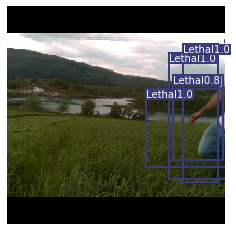

(1) Image
	+ Label: Warning, Conf: 0.76852
	+ Label: Danger, Conf: 0.70611
	+ Label: Danger, Conf: 0.47785
	+ Label: Warning, Conf: 0.47567
	+ Label: Warning, Conf: 0.41777


<Figure size 432x288 with 0 Axes>

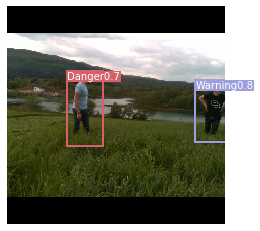

In [71]:
from matplotlib.ticker import NullLocator

cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

# Iterate through images and save plot of detections
for img_i, (image, detections) in enumerate(zip(b, outputs)):
    print("(%d) Image" % (img_i))

    # Create plot
    #img = np.array(Image.open(path))
    img = image.mul(255).permute(1, 2, 0).byte().cpu().numpy()
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Draw bounding boxes and labels of detections
    if detections is not None:
        # Rescale boxes to original image
        detections = rescale_boxes(detections, img_size, img.shape[:2])
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:

            print("\t+ Label: %s, Conf: %.5f" % (class_names[int(cls_pred)], cls_conf.item()))

            box_w = x2 - x1
            box_h = y2 - y1
            
            if cls_conf.item()<0.7:
                continue

            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            # Create a Rectangle patch
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
            # Add the bbox to the plot
            ax.add_patch(bbox)
            # Add label
            plt.text(
                x1,
                y1,
                s=class_names[int(cls_pred)]+"{:.1f}".format(cls_conf.item()),
                color="white",
                verticalalignment="top",
                bbox={"color": color, "pad": 0},
            )
        
    plt.axis("off")
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    plt.savefig("output/example_yolo{}.png".format(str(img_i)), bbox_inches="tight", pad_inches=0.0,dpi=250)
    plt.show()
    plt.close()